<center><h1>New York City Taxi Fare Prediction</h1>
    <h3>Projet Big Data</h3>
<h6>Flora Fevrier / Gabriel Foret / Paul Debuire / Alban Daniel / Solène Lemas</h6></center>
<hr/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import des packages

In [ ]:
import pandas as pd
from geopy.distance import geodesic
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb
from datetime import datetime, timedelta
import pytz
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

# Import des données

In [ ]:
# Chemin vers votre fichier CSV
chemin_du_fichier_csv = '/content/drive/MyDrive/Projet BIG DATA/train.csv'

# Taille des échantillons
taille_de_lechantillon = 490000
taille_ech_import = 500000

# Graine aléatoire
graine_aleatoire = 14

# Utilisation du paramètre nrows pour importer uniquement les premières lignes du fichier
taxi_initial = pd.read_csv(chemin_du_fichier_csv, nrows=taille_ech_import)
#taxi_test = pd.read_csv(chemin_du_fichier_csv)

# Utilisation sample pour extraire l'échantillon aléatoire
taxi_test = taxi_initial.sample(n=taille_de_lechantillon, random_state=graine_aleatoire)

In [ ]:
taxi_test.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
41174,2013-03-11 23:59:19.0000001,11.5,2013-03-11 23:59:19 UTC,-73.983516,40.760539,-73.989503,40.729851,1
145306,2009-02-13 18:03:00.000000126,13.3,2009-02-13 18:03:00 UTC,-74.000082,40.717630,-73.972865,40.677720,1
114953,2014-09-12 22:33:24.0000002,7.0,2014-09-12 22:33:24 UTC,-73.970233,40.760072,-73.982975,40.750617,1
490784,2010-12-06 19:16:00.000000217,12.1,2010-12-06 19:16:00 UTC,-74.015198,40.715988,-73.983272,40.722010,1
1026,2012-08-01 02:29:00.00000042,3.7,2012-08-01 02:29:00 UTC,-73.984174,40.758893,-73.989832,40.752624,1


Aperçu des données importées

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 490000  individus et  8  variables.


# Import des monuments

In [ ]:
monuments = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/monuments.csv', sep = '\t')
monuments.head()

,Monument,Longitude,Latitude
0,JFK Airport,-73.780526,40.648823
1,LaGuardia Airport,-73.875195,40.779340
2,Empire State Building,-73.985796,40.750383
3,Times Square,-73.985781,40.758863
4,Dumbo,-73.989523,40.703502


# Import des fuel_price

In [ ]:
fuel_price = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/Gasoline_Retail_Prices_Weekly_Average_by_Region__Beginning_2007.csv', sep = ',')

# Selection des prix uniquement de la ville de New York

selected_columns = ['Date', 'New York City Average ($/gal)']
fuel_price = fuel_price[selected_columns]

fuel_price.head()

,Date,New York City Average ($/gal)
0,01/29/2024,3.31
1,01/22/2024,3.31
2,01/15/2024,3.34
3,01/08/2024,3.36
4,01/01/2024,3.41


Le problème de notre df 'fuel_price', c'est qu'il contient les données des prix d'uniquement les lundis. Nous allons donc étendre le prix à la semaine entière

In [ ]:
# Convertir la colonne 'Date' en datetime
fuel_price['Date'] = pd.to_datetime(fuel_price['Date'])

# Déterminer la date d'origine
start_date = fuel_price['Date'].max()

# Créer un DataFrame avec les dates étendues
extended_dates = pd.DataFrame(pd.date_range(start=start_date, periods=len(fuel_price)*7, freq='-1D'), columns=['Date_Extended'])

# Répéter la colonne 'New York City Average ($/gal)' pour chaque semaine
extended_dates['New York City Average ($/gal)'] = fuel_price['New York City Average ($/gal)'].repeat(7).reset_index(drop=True)

fuel_price = extended_dates

# Afficher le résultat
fuel_price.head()

,Date_Extended,New York City Average ($/gal)
0,2024-01-29,3.31
1,2024-01-28,3.31
2,2024-01-27,3.31
3,2024-01-26,3.31
4,2024-01-25,3.31


Nous avons donc étendu les prix du lundi aux autres jours de la semaine

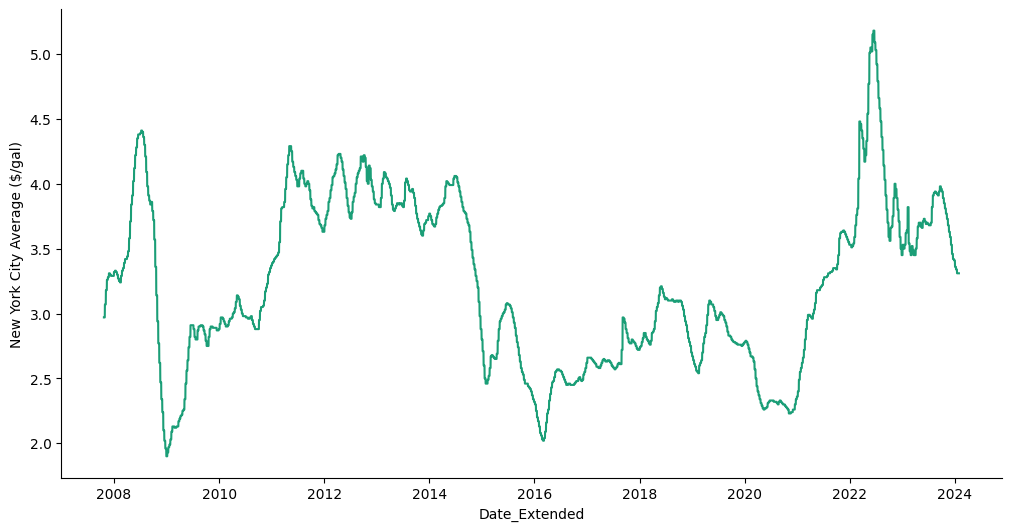

In [ ]:
# @title Date_Extended vs New York City Average ($/gal)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date_Extended']
  ys = series['New York City Average ($/gal)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = fuel_price.sort_values('Date_Extended', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date_Extended')
_ = plt.ylabel('New York City Average ($/gal)')

# Traitement des données manquantes et valeurs aberrantes

Nombre de NA par variable

In [ ]:
pd.isna(taxi_test).sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

Suppression des lignes avec données manquantes : courses non terminées

In [ ]:
taxi_test = taxi_test.dropna()

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 489995  individus et  8  variables.


In [ ]:
# Colonne pickup_datetime en type datetime
taxi_test['pickup_datetime'] = pd.to_datetime(taxi_test['pickup_datetime'])

# Définir le fuseau horaire de destination (New York)
destination_timezone = pytz.timezone('America/New_York')

# Convertirl'heure de pickup_datetime à l'heure de New York
taxi_test['pickup_datetime_ny'] = taxi_test['pickup_datetime'].dt.tz_convert(destination_timezone)

# Puis suppression de l'ancienne pickup_datetime
taxi_test = taxi_test.drop('pickup_datetime', axis=1)

Nous avons donc désormais la variable de temporalité au fuseau horaire de New York

In [ ]:
# on récupère que la date
taxi_test['datedep']=taxi_test['pickup_datetime_ny'].dt.date

In [ ]:
taxi_test['datedep'] = pd.to_datetime(taxi_test['datedep'], errors='coerce')

In [ ]:
# on vérifie si données manquantes = mauvaise conversion donc mauvaise date
donnees_aberrantes = taxi_test[taxi_test['datedep'].isnull()]

In [ ]:
donnees_aberrantes.shape

(0, 9)

Nous n'avons donc aucune valeur aberrante. Cette variable nous servira pour la construction du Power BI

In [ ]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep
41174,2013-03-11 23:59:19.0000001,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11 19:59:19-04:00,2013-03-11
145306,2009-02-13 18:03:00.000000126,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13 13:03:00-05:00,2009-02-13
114953,2014-09-12 22:33:24.0000002,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12 18:33:24-04:00,2014-09-12
490784,2010-12-06 19:16:00.000000217,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06 14:16:00-05:00,2010-12-06
1026,2012-08-01 02:29:00.00000042,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31 22:29:00-04:00,2012-07-31


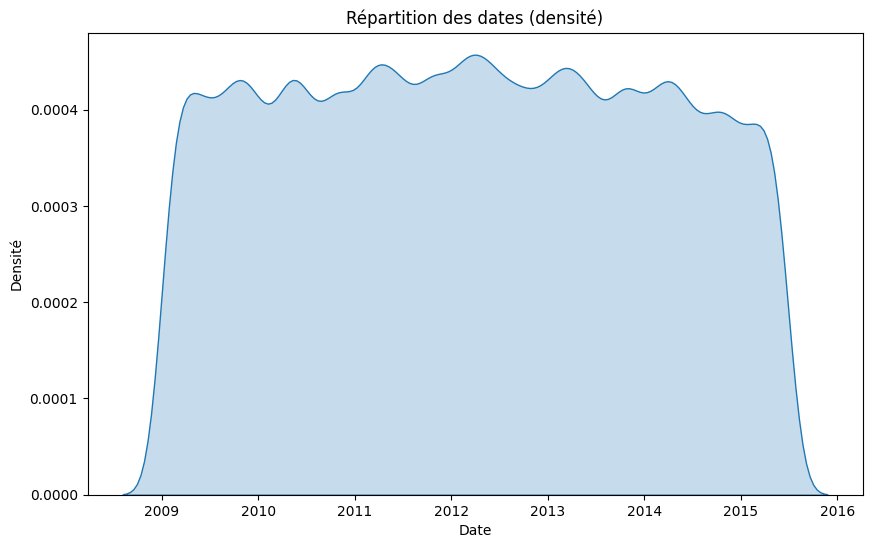

In [ ]:
# graphique
plt.figure(figsize=(10, 6))
sb.kdeplot(taxi_test['datedep'], fill=True)
plt.title('Répartition des dates (densité)')
plt.xlabel('Date')
plt.ylabel('Densité')
plt.show()

Voici la répartition de la nouvelle variable créée

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 489995  individus et  9  variables.


Pour rappel, la latitude est comprise entre [-90;90]. Nous allons donc supprimer les valeurs en dehors de cette intervalle

In [ ]:
# variable Pickup_latitude
cond=(taxi_test['pickup_latitude']<=90) & (taxi_test['pickup_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [ ]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

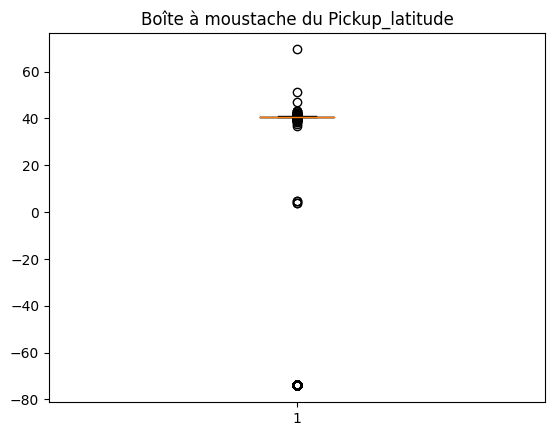

In [ ]:
#graphique
plt.boxplot(taxi_test.pickup_latitude)
plt.title("Boîte à moustache du Pickup_latitude")
plt.show()

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 480714  individus et  9  variables.


Même chose, mais cette fois-ci pour l'arrivée. La latitude est comprise entre [-90;90] : on supprime les valeurs en dehors de cette intervalle

In [ ]:
# variable Dropoff_latitude
cond=(taxi_test['dropoff_latitude']<=90) & (taxi_test['dropoff_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [ ]:
# suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

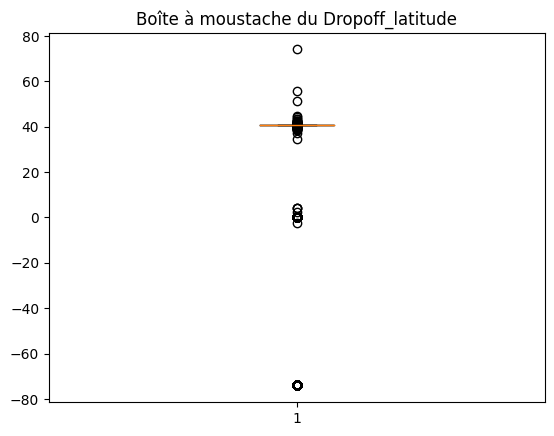

In [ ]:
# graphique
plt.boxplot(taxi_test.dropoff_latitude)
plt.title("Boîte à moustache du Dropoff_latitude")
plt.show()

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 480711  individus et  9  variables.


Pour la longitude, nous allons supprimer les valeurs en dehors de cet intervalle [-180;180]

In [ ]:
# variable Pickup_longitude
cond=(taxi_test['pickup_longitude']<=180) & (taxi_test['pickup_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [ ]:
# suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

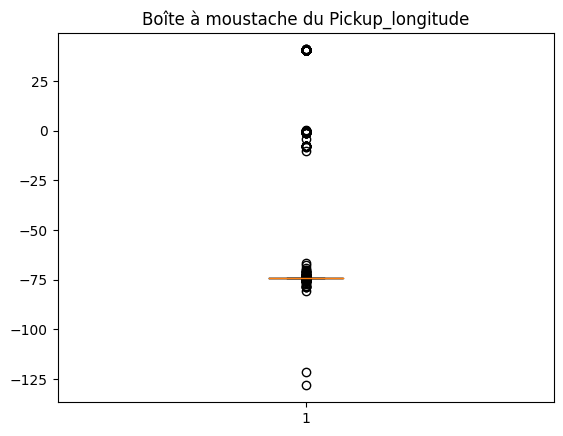

In [ ]:
# graphique
plt.boxplot(taxi_test.pickup_longitude)
plt.title("Boîte à moustache du Pickup_longitude")
plt.show()

In [ ]:
# dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 480705  individus et  9  variables.


Même chose pour l'arrivée : la longitude est comprise entre [-180;180] : on supprime les valeurs en dehors de cette intervalle

In [ ]:
# variable Dropoff_longitude
cond=(taxi_test['dropoff_longitude']<=180) & (taxi_test['dropoff_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [ ]:
# suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

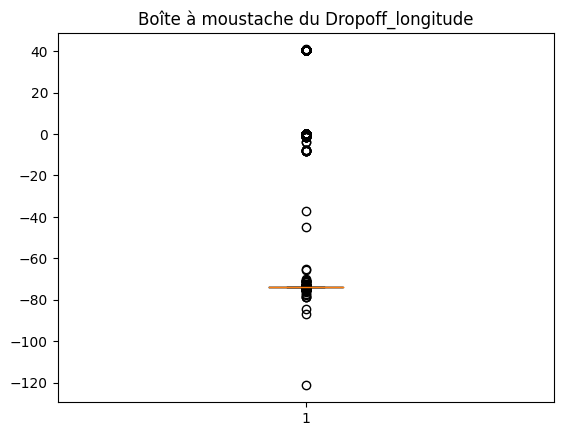

In [ ]:
# graphique
plt.boxplot(taxi_test.dropoff_longitude)
plt.title("Boîte à moustache du Dropoff_longitude")
plt.show()

In [ ]:
# dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 480701  individus et  9  variables.


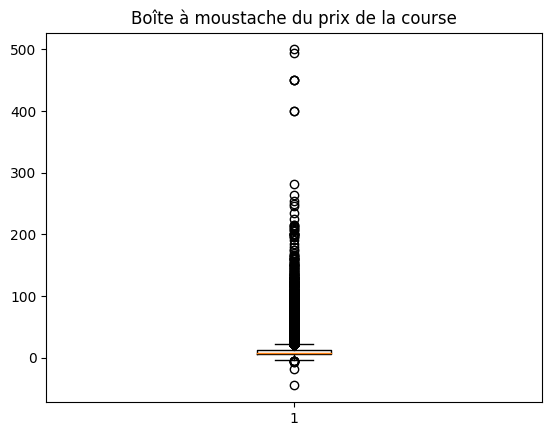

In [ ]:
# données aberrantes de la variable fare_amount
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()
# données aberrantes

Nous remarquons certaines valeurs aberrantes lors de notre analyse

Notamment les courses ayant un prix négatif, nous décidons on supprime les lignes qui ont un prix de course négatif

In [ ]:
taxi_test.drop(taxi_test[taxi_test['fare_amount']<0].index,inplace=True)

Nous remarquons aussi des valeurs extrêmes en termes de tarif. Nous choisissons de supprimer les 1% des trajets les plus cher

In [ ]:
# on détermine le prix max d'une course pour 99% des individus
bornesup = taxi_test['fare_amount'].quantile(0.99)

In [ ]:
# on supprime les lignes qui ont un prix supérieur à cette borne
taxi_test.drop(taxi_test[taxi_test['fare_amount']>bornesup].index,inplace=True)

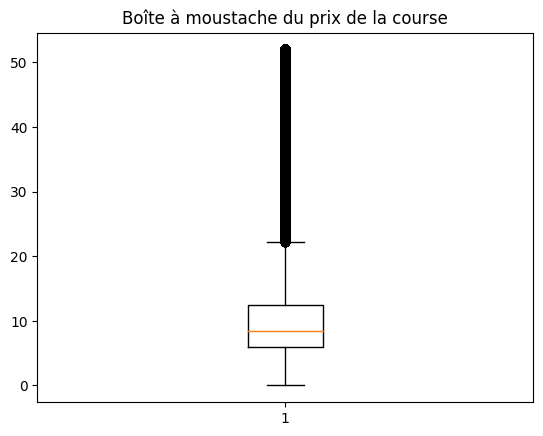

In [ ]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 475874  individus et  9  variables.


Nous avons donc des trajets avec des tarifs bien plus cohérent

Vérification de si le nombre de passagers n'est pas incohérent

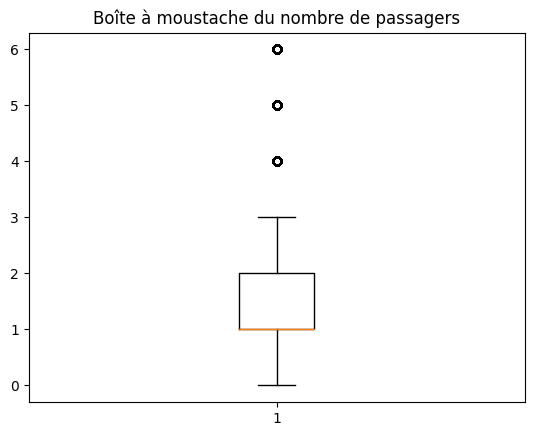

In [ ]:
# variable Passenger_count
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()

Nous supprimons les lignes où le nombre de passagers est supérieur à 8 (un van a 9 places)

In [ ]:
taxi_test.drop(taxi_test[taxi_test['passenger_count']==0].index,inplace=True)
taxi_test.drop(taxi_test[taxi_test['passenger_count']>8].index,inplace=True)

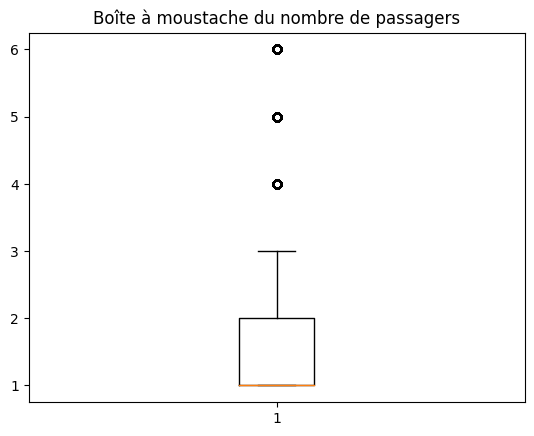

In [ ]:
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 474161  individus et  9  variables.


# Feature Engineering

Calcul de la distance de Manhattan entre les 4 variables de coordonnées

In [ ]:
taxi_test['manhattan_distance_km'] = taxi_test.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['pickup_longitude'])).kilometers +
                                               geodesic((row['dropoff_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)

On regarde si présence de données aberrantes dans la nouvelle variable manhattan_distance_km

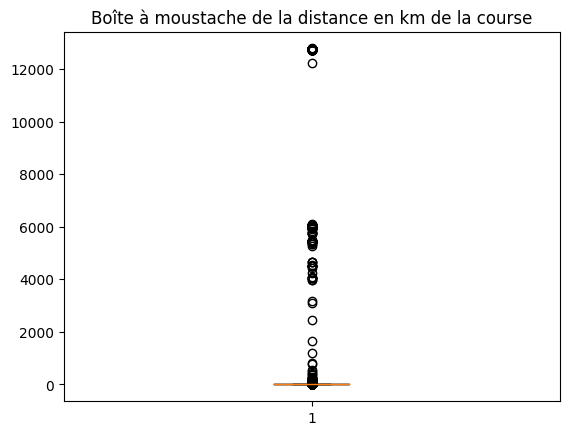

In [ ]:
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()

# données aberrantes ? (valeurs trop importantes en km)

On détermine la distance max d'une course pour 99% des individus

In [ ]:
bornesup = taxi_test['manhattan_distance_km'].quantile(0.99)

On supprime les lignes qui ont une distance supérieur à cette borne

In [ ]:
taxi_test.drop(taxi_test[taxi_test['manhattan_distance_km']>bornesup].index,inplace=True)

On supprime aussi les trajets avec une distance de 0km

In [ ]:
taxi_test.drop(taxi_test[taxi_test['manhattan_distance_km']>bornesup].index,inplace=True)

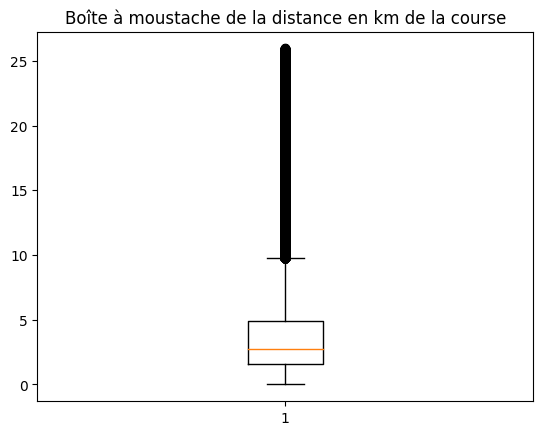

In [ ]:
# Vérification
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()

Nous avons désormais des trajets ayant des distances qui ne dépassent pas les 30km sur la ville de New York

Création des classes de distances également réparties de la variable 'manhattan_distance_km'

In [ ]:
# Utiliser qcut pour découper en 5 classes

taxi_test['distance_classe_manhattan_kms'], bins = pd.qcut(taxi_test['manhattan_distance_km'], q=5, labels=False, retbins=True)

# Créer des noms de classe basés sur les intervalles

class_names = [f'[{round(bins[i], 2)}; {round(bins[i+1], 2)}[' for i in range(len(bins)-1)]
class_names.append(f'[{round(bins[-1], 2)}; inf[')

# Attribuer les noms de classe à la variable 'distance_classe'

taxi_test['distance_classe_manhattan_kms'] = taxi_test['distance_classe_manhattan_kms'].apply(lambda x: class_names[x])

#taxi_test.drop("manhattan_distance_km", axis=1, inplace=True)

taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,manhattan_distance_km,distance_classe_manhattan_kms
41174,2013-03-11 23:59:19.0000001,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11 19:59:19-04:00,2013-03-11,3.913640,[3.36; 5.68[
145306,2009-02-13 18:03:00.000000126,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13 13:03:00-05:00,2009-02-13,6.732953,[5.68; 25.95[
114953,2014-09-12 22:33:24.0000002,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12 18:33:24-04:00,2014-09-12,2.126051,[1.39; 2.21[
490784,2010-12-06 19:16:00.000000217,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06 14:16:00-05:00,2010-12-06,3.366088,[3.36; 5.68[
1026,2012-08-01 02:29:00.00000042,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31 22:29:00-04:00,2012-07-31,1.173980,[0.0; 1.39[


Vérification de la bonne distribution de la nouvelle variable de classe

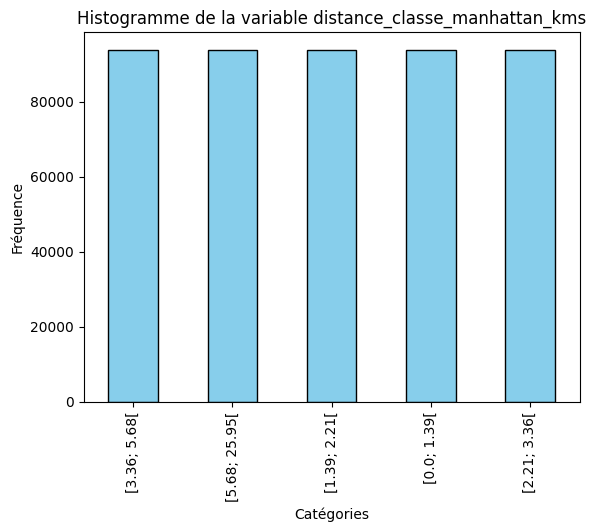

In [ ]:
taxi_test['distance_classe_manhattan_kms'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Histogramme de la variable distance_classe_manhattan_kms")
plt.xlabel("Catégories")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
# Création de la variable 'type_vehicule'

# taxi_test['type_vehicule'] = ['Voiture' if int(count) < 5 else 'Van' for count in taxi_test['passenger_count']]

In [ ]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,manhattan_distance_km,distance_classe_manhattan_kms
41174,2013-03-11 23:59:19.0000001,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11 19:59:19-04:00,2013-03-11,3.913640,[3.36; 5.68[
145306,2009-02-13 18:03:00.000000126,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13 13:03:00-05:00,2009-02-13,6.732953,[5.68; 25.95[
114953,2014-09-12 22:33:24.0000002,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12 18:33:24-04:00,2014-09-12,2.126051,[1.39; 2.21[
490784,2010-12-06 19:16:00.000000217,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06 14:16:00-05:00,2010-12-06,3.366088,[3.36; 5.68[
1026,2012-08-01 02:29:00.00000042,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31 22:29:00-04:00,2012-07-31,1.173980,[0.0; 1.39[


Nous allons charger le fichier GeoJSON qui va nous permettre de délimiter les quartiers de la ville de New York

In [ ]:
# Charger le fichier GeoJSON
gdf = gpd.read_file('/content/drive/MyDrive/Projet BIG DATA/newyork-borough.geojson')

In [ ]:
# conservation des colonnes utiles
gdf=gdf[['BoroCode', 'BoroName', 'geometry']]

In [ ]:
# Créer un GeoDataFrame à partir du DataFrame des quartiers de New York
quartiers_gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [ ]:
# Créer une fonction pour attribuer le quartier en fonction de la latitude et de la longitude
def trouver_quartier(latitude, longitude, gdf_quartiers):
    point = Point(longitude, latitude)
    for idx, row in gdf_quartiers.iterrows():
        if point.within(row['geometry']):
            return row['BoroName']
    return 'Quartier en dehors de New York'

Appliquer la fonction pour obtenir le quartier de départ et d'arrivée

In [ ]:
taxi_test['quartier_depart'] = taxi_test.apply(lambda row: trouver_quartier(row['pickup_latitude'], row['pickup_longitude'], quartiers_gdf), axis=1)
taxi_test['quartier_arrivee'] = taxi_test.apply(lambda row: trouver_quartier(row['dropoff_latitude'], row['dropoff_longitude'], quartiers_gdf), axis=1)

In [ ]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,manhattan_distance_km,distance_classe_manhattan_kms,quartier_depart,quartier_arrivee
41174,2013-03-11 23:59:19.0000001,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11 19:59:19-04:00,2013-03-11,3.913640,[3.36; 5.68[,Manhattan,Manhattan
145306,2009-02-13 18:03:00.000000126,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13 13:03:00-05:00,2009-02-13,6.732953,[5.68; 25.95[,Manhattan,Brooklyn
114953,2014-09-12 22:33:24.0000002,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12 18:33:24-04:00,2014-09-12,2.126051,[1.39; 2.21[,Manhattan,Manhattan
490784,2010-12-06 19:16:00.000000217,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06 14:16:00-05:00,2010-12-06,3.366088,[3.36; 5.68[,Manhattan,Manhattan
1026,2012-08-01 02:29:00.00000042,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31 22:29:00-04:00,2012-07-31,1.173980,[0.0; 1.39[,Manhattan,Manhattan


Nous allons créer une fonction pour calculer la distance entre deux points (en mètres)

Celle ci va nous permettre de créer (à l'aide de notre jeu de données sur les monuments situés dans la ville de New York), 2 variables binaires, 1 si il y a un momument (aéroport, gare, monuments...) situés à moins de 500m du lieu de départ et de même pour l'arrivée

In [ ]:
def distance(coord1, coord2):
    return geodesic(coord1, coord2).meters

# Seuil de proximité en mètres
seuil_proximite = 500

# Création des variables 'proximite_depart_monument' et 'proximite_arrivee_monument'
taxi_test['proximite_depart_monument'] = taxi_test.apply(
    lambda row: 1 if any(distance((row['pickup_latitude'], row['pickup_longitude']), (mon['Latitude'], mon['Longitude'])) <= seuil_proximite for _, mon in monuments.iterrows()) else 0,
    axis=1
)

taxi_test['proximite_arrivee_monument'] = taxi_test.apply(
    lambda row: 1 if any(distance((row['dropoff_latitude'], row['dropoff_longitude']), (mon['Latitude'], mon['Longitude'])) <= seuil_proximite for _, mon in monuments.iterrows()) else 0,
    axis=1
)

In [ ]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,manhattan_distance_km,distance_classe_manhattan_kms,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument
41174,2013-03-11 23:59:19.0000001,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11 19:59:19-04:00,2013-03-11,3.913640,[3.36; 5.68[,Manhattan,Manhattan,1,0
145306,2009-02-13 18:03:00.000000126,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13 13:03:00-05:00,2009-02-13,6.732953,[5.68; 25.95[,Manhattan,Brooklyn,0,0
114953,2014-09-12 22:33:24.0000002,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12 18:33:24-04:00,2014-09-12,2.126051,[1.39; 2.21[,Manhattan,Manhattan,0,1
490784,2010-12-06 19:16:00.000000217,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06 14:16:00-05:00,2010-12-06,3.366088,[3.36; 5.68[,Manhattan,Manhattan,0,0
1026,2012-08-01 02:29:00.00000042,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31 22:29:00-04:00,2012-07-31,1.173980,[0.0; 1.39[,Manhattan,Manhattan,1,1


Création des fonctions pour créer les variables de temporalité

In [ ]:
def moment_journee(heure):
    """
    Fonction permettant de récupérer le moment de la journée en fonction d'une heure passée en paramètre
    Parameters
    ----------
    heure : int (heure de la journée dont ou souhaite récupérer le moment)
    """
    if heure>=5 and heure<12 :
        return("Matin")
    elif heure>=12 and heure<14 :
        return('Midi')
    elif heure>=14 and heure<18 :
        return("Après-midi")
    elif heure>=18 and heure<21 :
        return('Soir')
    else :
        return('Nuit')

In [ ]:
def moment_semaine(jour):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    jour : int (numéro du jour dont on souhaite récupérer le moment de la semaine (semaine ou week-end) : 0 pour lundi, 1 pour mardi...)
    """
    if jour<=4 :
        return("Semaine")#Semaine
    else :
        return('Week-end')#Week-End

In [ ]:
def saison(mois):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    mois : int (numéro du mois dont on souhaite récupérer la saison)
    """
    if mois>=3 and mois<6 :
        return("Printemps")
    elif mois>=6 and mois<9 :
        return('Été')
    elif mois>=9 and mois<12 :
        return("Automne")
    else :
        return('Hiver')

In [ ]:
def is_holiday(date):
    """
    Fonction qui permet de récupérer si oui ou non le jour passé en paramètre est férié dans l'état de New-York
    Parameters
    ----------
    date : datetime (date de laquelle on souhaite savoir si férié ou non)
    """
    return date in holidays.UnitedStates(years=date.year, state='NY')

Nous appliquons nos fonctions à notre variable de temporalité

In [ ]:
#Mise au format datetime de la variable pickup_datetime_ny
taxi_test['pickup_datetime_ny'] = pd.to_datetime(taxi_test['pickup_datetime_ny'])

#Jour de la semaine de début de trajet
taxi_test['pickup_day'] = taxi_test['pickup_datetime_ny'].dt.day_name()

#Mois de début de trajet
taxi_test['pickup_month'] = taxi_test['pickup_datetime_ny'].dt.month_name()

#Trimestre de début de trajet
taxi_test['pickup_quarter'] = taxi_test['pickup_datetime_ny'].dt.quarter

#Année de début de trajet
taxi_test['pickup_year'] = taxi_test['pickup_datetime_ny'].dt.year

#Saison de début de trajet
taxi_test['pickup_season'] = taxi_test['pickup_datetime_ny'].dt.month.map(saison)

#Moment de la journée
taxi_test['pickup_daytime'] = taxi_test['pickup_datetime_ny'].dt.hour.map(moment_journee)

#Moment de la semaine
taxi_test['pickup_weektime'] = taxi_test['pickup_datetime_ny'].dt.weekday.map(moment_semaine)

#Jour férié
taxi_test['holidays'] = taxi_test['pickup_datetime_ny'].dt.date.apply(is_holiday)

Nous allons créer une variable binaire d'heures de pointes (entre 7h et 10h)  et (entre 16h et 19h) décidé via le site du Routard : https://www.routard.com/guide/new_york/1874/transports.htm#:~:text=Les%20heures%20de%20pointe%20se,de%20la%20Metropolitan%20Transportation%20Authority.

In [ ]:
# Création d'une variable d'heure de pointe
taxi_test['peak_hour'] = taxi_test['pickup_datetime_ny'].apply(
    lambda x: 1 if (x.hour >= 7 and x.hour < 10) or (x.hour >= 16 and x.hour < 19) else 0
)

Nous allons réaliser la jointure sur la date entre notre df 'taxi_test' et le df 'fuel_price'

In [ ]:
# Convertir la colonne 'datedep' en type datetime64[ns] et utilisation le fuseau horaire UTC
taxi_test['datedep'] = pd.to_datetime(taxi_test['datedep']).dt.tz_localize(None)

# Convertir la colonne 'Date' en type datetime64[ns] et utilisation le fuseau horaire UTC
fuel_price['Date_Extended'] = pd.to_datetime(fuel_price['Date_Extended']).dt.tz_localize(None)

# Fusionner les DataFrames sur la colonne de date
taxi_test = pd.merge(taxi_test, fuel_price, left_on='datedep', right_on='Date_Extended', how='left')

# Remplir les valeurs manquantes en avant pour étendre la valeur du lundi à tous les jours de la semaine
taxi_test['New York City Average ($/gal)'] = taxi_test['New York City Average ($/gal)'].fillna(method='ffill')

In [ ]:
# Compter le nombre de NaN dans la colonne 'New York City Average ($/gal)'
nan_count = taxi_test['New York City Average ($/gal)'].isna().sum()

# Afficher le résultat
print(f"Nombre de NaN dans la colonne 'New York City Average ($/gal)': {nan_count}")

Nombre de NaN dans la colonne 'New York City Average ($/gal)': 0


In [ ]:
# Pour les valeurs nulles, nous allons les remplacer par la moyenne de la variable

# Calculer la moyenne de la variable 'New York City Average ($/gal)'
mean_fuel_price = taxi_test['New York City Average ($/gal)'].mean()

# Remplacer les valeurs nulles par la moyenne calculée
taxi_test['New York City Average ($/gal)'].fillna(mean_fuel_price, inplace=True)

In [ ]:
# Supprimer les lignes où à la fois quartier_depart et quartier_arrivee ont la valeur 'Quartier en dehors de New York'
taxi_test = taxi_test[(taxi_test['quartier_depart'] != 'Quartier en dehors de New York') &
                      (taxi_test['quartier_arrivee'] != 'Quartier en dehors de New York')]

# Données finales

Suppression des variables inutiles au ML

In [ ]:
#taxi_test.drop("passenger_count", axis=1, inplace=True)
taxi_test.drop("key", axis=1, inplace=True)
taxi_test.drop("pickup_datetime_ny", axis=1, inplace=True)
taxi_test.drop("pickup_year", axis=1, inplace=True)
#taxi_test.drop("pickup_longitude", axis=1, inplace=True)
#taxi_test.drop("pickup_latitude", axis=1, inplace=True)
#taxi_test.drop("dropoff_longitude", axis=1, inplace=True)
#taxi_test.drop("dropoff_latitude", axis=1, inplace=True)
#taxi_test.drop("datedep", axis=1, inplace=True)
taxi_test.drop("Date_Extended", axis=1, inplace=True)
#taxi_test.drop("manhattan_distance_km", axis=1, inplace=True)

<ipython-input-78-a6751dcf5444>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_test.drop("key", axis=1, inplace=True)
<ipython-input-78-a6751dcf5444>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_test.drop("pickup_datetime_ny", axis=1, inplace=True)
<ipython-input-78-a6751dcf5444>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_test.drop("pickup_year", axis=1, inplace=True)


In [ ]:
# dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 467832  individus et  22  variables.


In [ ]:
taxi_test.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datedep,manhattan_distance_km,distance_classe_manhattan_kms,quartier_depart,...,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_season,pickup_daytime,pickup_weektime,holidays,peak_hour,New York City Average ($/gal)
0,11.5,-73.983516,40.760539,-73.989503,40.729851,1,2013-03-11,3.913640,[3.36; 5.68[,Manhattan,...,0,Monday,March,1,Printemps,Soir,Semaine,False,0,4.05
1,13.3,-74.000082,40.717630,-73.972865,40.677720,1,2009-02-13,6.732953,[5.68; 25.95[,Manhattan,...,0,Friday,February,1,Hiver,Midi,Semaine,False,0,2.13
2,7.0,-73.970233,40.760072,-73.982975,40.750617,1,2014-09-12,2.126051,[1.39; 2.21[,Manhattan,...,1,Friday,September,3,Automne,Soir,Semaine,False,1,3.77
3,12.1,-74.015198,40.715988,-73.983272,40.722010,1,2010-12-06,3.366088,[3.36; 5.68[,Manhattan,...,0,Monday,December,4,Hiver,Après-midi,Semaine,False,0,3.23
4,3.7,-73.984174,40.758893,-73.989832,40.752624,1,2012-07-31,1.173980,[0.0; 1.39[,Manhattan,...,1,Tuesday,July,3,Été,Nuit,Semaine,False,0,3.93


# Export des données

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive')

In [ ]:
# Export du DataFrame au format CSV vers votre Google Drive
#taxi_test.to_excel('/content/drive/MyDrive/Projet BIG DATA/donnees_pbi_xlsx.xlsx', index=False)

# Statistiques bivariées

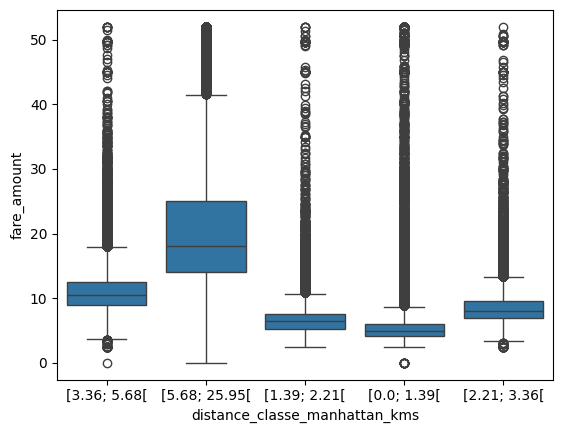

In [ ]:
# fare_amount*distance_classe_manhattan_kms
sb.boxplot(x='distance_classe_manhattan_kms', y='fare_amount', data=taxi_test)
plt.show()

In [ ]:
# fare_amount*type_vehicule
#sb.boxplot(x='type_vehicule', y='fare_amount', data=taxi_test)
#plt.show()

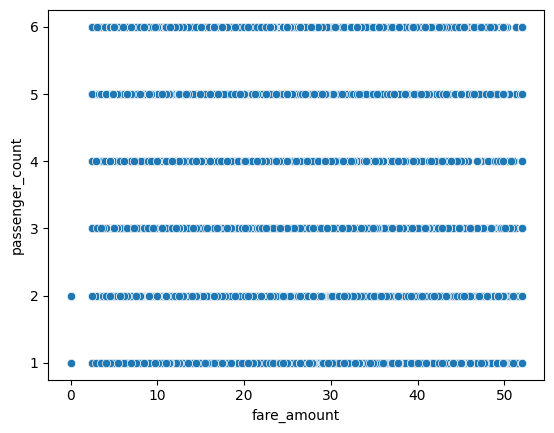

In [ ]:
# Créer un nuage de points
sb.scatterplot(x='fare_amount', y='passenger_count', data=taxi_test)
plt.show()

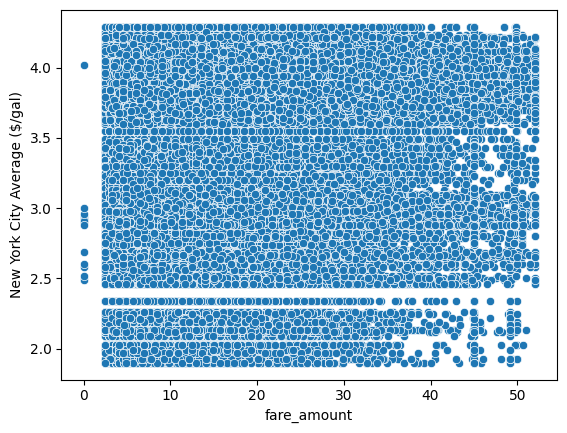

In [ ]:
# Créer un nuage de points
sb.scatterplot(x='fare_amount', y='New York City Average ($/gal)', data=taxi_test)
plt.show()

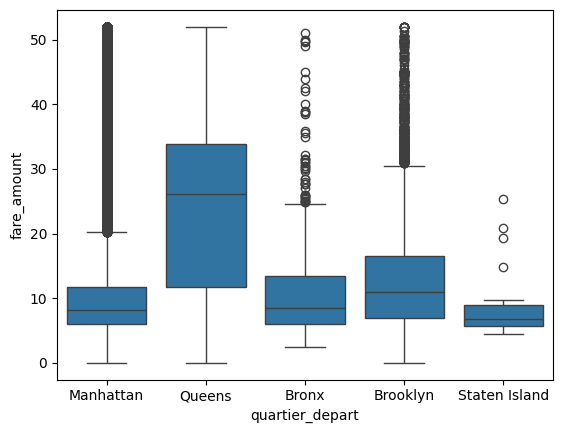

In [ ]:
# fare_amount*quartier_depart
sb.boxplot(x='quartier_depart', y='fare_amount', data=taxi_test)
plt.show()

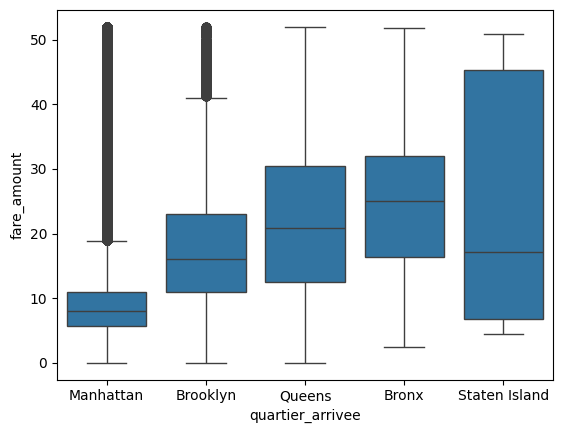

In [ ]:
# fare_amount*quartier_arrivee
sb.boxplot(x='quartier_arrivee', y='fare_amount', data=taxi_test)
plt.show()

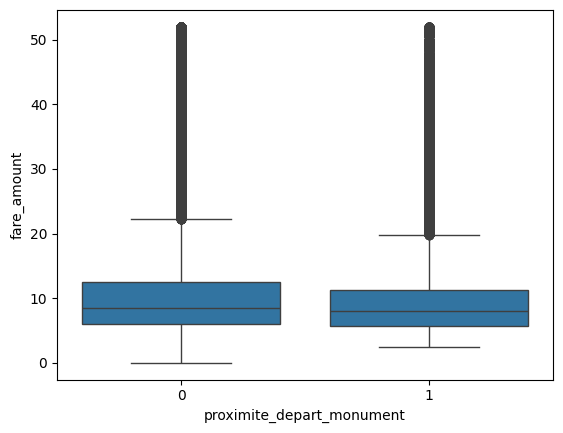

In [ ]:
# fare_amount*proximite_depart_monument
sb.boxplot(x='proximite_depart_monument', y='fare_amount', data=taxi_test)
plt.show()

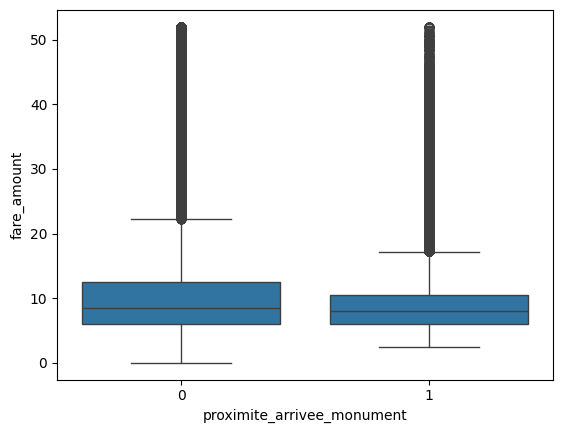

In [ ]:
# fare_amount*proximite_arrivee_monument
sb.boxplot(x='proximite_arrivee_monument', y='fare_amount', data=taxi_test)
plt.show()

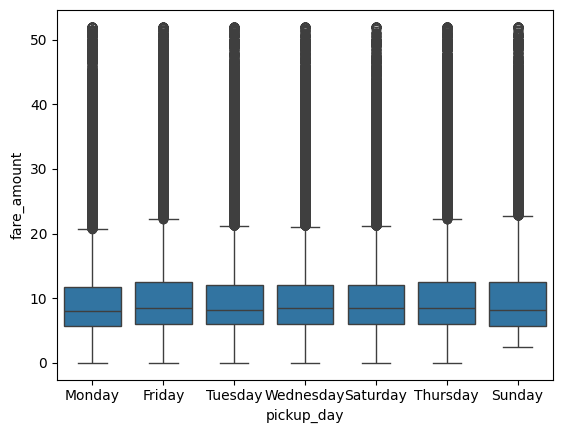

In [ ]:
# fare_amount*pickup_day
sb.boxplot(x='pickup_day', y='fare_amount', data=taxi_test)
plt.show()

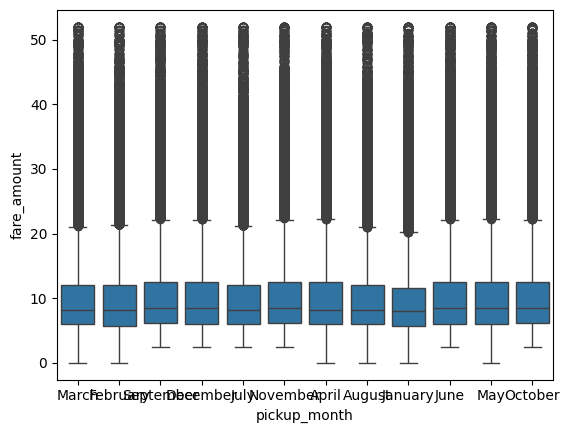

In [ ]:
# fare_amount*pickup_month
sb.boxplot(x='pickup_month', y='fare_amount', data=taxi_test)
plt.show()

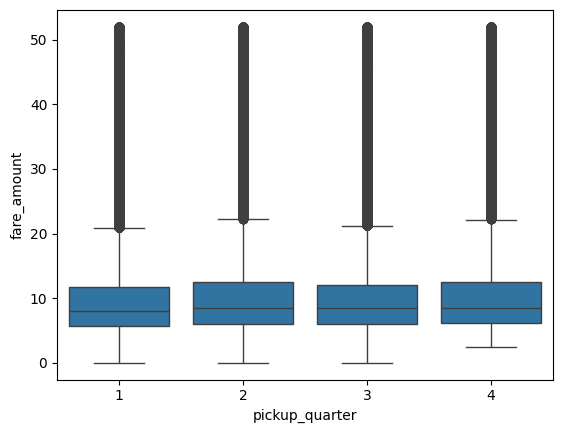

In [ ]:
# fare_amount*pickup_quarter
sb.boxplot(x='pickup_quarter', y='fare_amount', data=taxi_test)
plt.show()

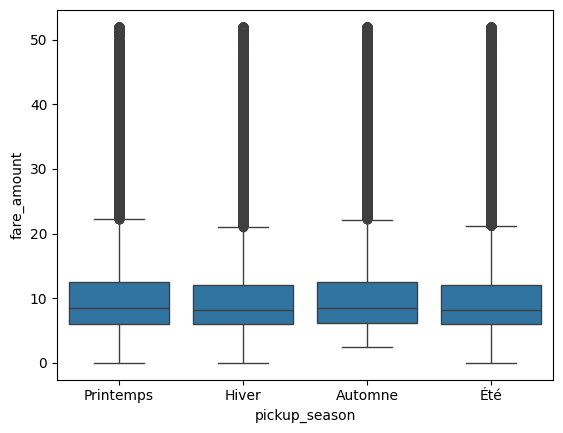

In [ ]:
# fare_amount*pickup_season
sb.boxplot(x='pickup_season', y='fare_amount', data=taxi_test)
plt.show()

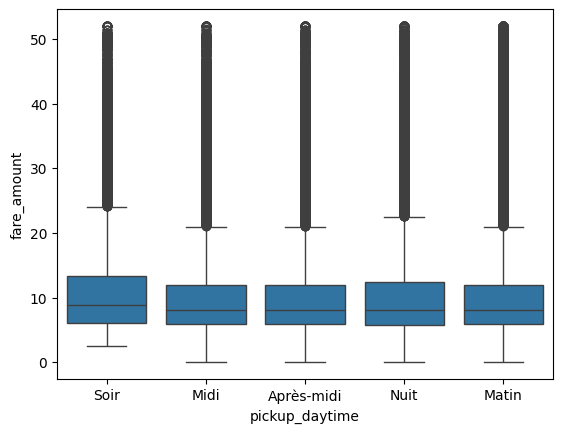

In [ ]:
# fare_amount*pickup_daytime
sb.boxplot(x='pickup_daytime', y='fare_amount', data=taxi_test)
plt.show()

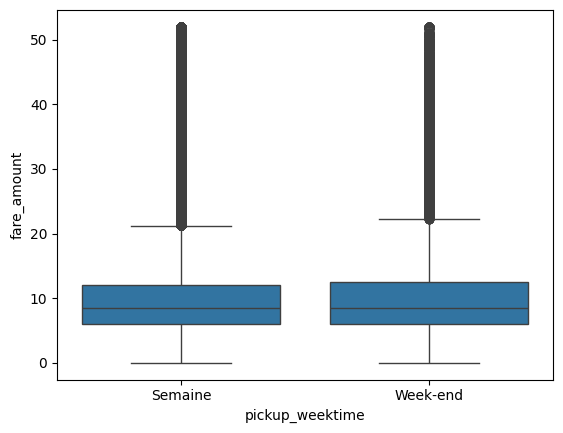

In [ ]:
# fare_amount*pickup_weektime
sb.boxplot(x='pickup_weektime', y='fare_amount', data=taxi_test)
plt.show()

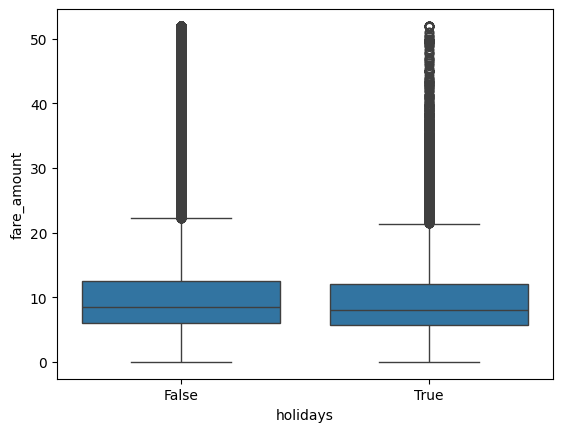

In [ ]:
# fare_amount*holidays
sb.boxplot(x='holidays', y='fare_amount', data=taxi_test)
plt.show()

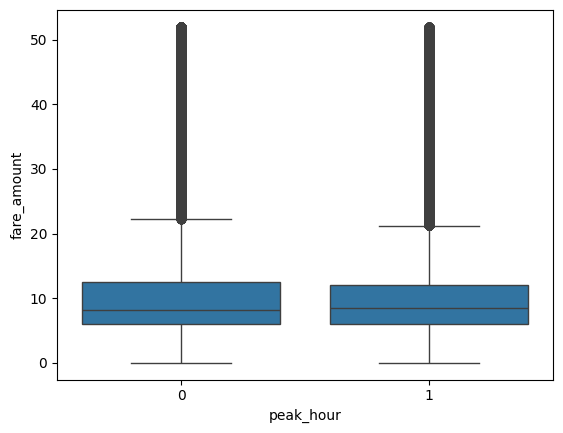

In [ ]:
# fare_amount*peak_hour
sb.boxplot(x='peak_hour', y='fare_amount', data=taxi_test)
plt.show()

In [ ]:
def summary_stats_grouped(taxi_test, quantitative_var, qualitative_var):
    # Calculer la moyenne groupée par la variable qualitative
    mean_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].mean()

    # Calculer la médiane groupée par la variable qualitative
    median_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].median()

    # Calculer les quartiles groupés par la variable qualitative
    quartiles_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].quantile([0.25, 0.5, 0.75])

    # Calculer le minimum groupé par la variable qualitative
    min_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].min()

    # Calculer le maximum groupé par la variable qualitative
    max_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].max()

    # Retourner les résultats
    return mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group

mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'distance_classe_manhattan_kms')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
distance_classe_manhattan_kms
[0.0; 1.39[       5.732489
[1.39; 2.21[      6.752544
[2.21; 3.36[      8.458481
[3.36; 5.68[     11.056042
[5.68; 25.95[    20.425217
Name: fare_amount, dtype: float64

Médiane par groupe:
distance_classe_manhattan_kms
[0.0; 1.39[       4.9
[1.39; 2.21[      6.5
[2.21; 3.36[      8.0
[3.36; 5.68[     10.5
[5.68; 25.95[    18.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
distance_classe_manhattan_kms      
[0.0; 1.39[                    0.25     4.1
                               0.50     4.9
                               0.75     6.0
[1.39; 2.21[                   0.25     5.3
                               0.50     6.5
                               0.75     7.5
[2.21; 3.36[                   0.25     6.9
                               0.50     8.0
                               0.75     9.5
[3.36; 5.68[                   0.25     8.9
                               0.50    10.5
                               0.75    12.5

In [ ]:
#mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'type_vehicule')

#print("Moyenne par groupe:")
#print(mean_by_group)

#print("\nMédiane par groupe:")
#print(median_by_group)

#print("\nQuartiles par groupe:")
#print(quartiles_by_group)

#print("\nMinimum par groupe:")
#print(min_by_group)

#print("\nMaximum par groupe:")
#print(max_by_group)

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_depart')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_depart
Bronx            11.584317
Brooklyn         12.925066
Manhattan         9.822950
Queens           24.172798
Staten Island     9.113636
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_depart
Bronx             8.5
Brooklyn         11.0
Manhattan         8.1
Queens           26.1
Staten Island     6.7
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_depart      
Bronx            0.25     6.000
                 0.50     8.500
                 0.75    13.500
Brooklyn         0.25     7.000
                 0.50    11.000
                 0.75    16.500
Manhattan        0.25     6.000
                 0.50     8.100
                 0.75    11.700
Queens           0.25    11.700
                 0.50    26.100
                 0.75    33.830
Staten Island    0.25     5.700
                 0.50     6.700
                 0.75     8.975
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_depart
Bronx            2

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_arrivee')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_arrivee
Bronx            24.148760
Brooklyn         17.976182
Manhattan         9.410683
Queens           21.807214
Staten Island    24.285500
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_arrivee
Bronx            25.0
Brooklyn         16.0
Manhattan         8.0
Queens           20.9
Staten Island    17.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_arrivee      
Bronx             0.25    16.30
                  0.50    25.00
                  0.75    32.00
Brooklyn          0.25    10.90
                  0.50    16.00
                  0.75    23.00
Manhattan         0.25     5.70
                  0.50     8.00
                  0.75    11.00
Queens            0.25    12.50
                  0.50    20.90
                  0.75    30.50
Staten Island     0.25     6.80
                  0.50    17.10
                  0.75    45.26
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_arrivee
Bronx         

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_depart_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_depart_monument
0    10.573144
1    10.067312
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_depart_monument
0    8.5
1    8.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_depart_monument      
0                          0.25     6.0
                           0.50     8.5
                           0.75    12.5
1                          0.25     5.7
                           0.50     8.0
                           0.75    11.3
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_depart_monument
0    0.0
1    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_depart_monument
0    52.0
1    52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_arrivee_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_arrivee_monument
0    10.716938
1     9.412522
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_arrivee_monument
0    8.5
1    8.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_arrivee_monument      
0                           0.25     6.0
                            0.50     8.5
                            0.75    12.5
1                           0.25     6.0
                            0.50     8.0
                            0.75    10.5
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_arrivee_monument
0    0.0
1    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_arrivee_monument
0    52.0
1    52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_day')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_day
Friday       10.592157
Monday       10.355354
Saturday     10.260612
Sunday       10.687257
Thursday     10.660907
Tuesday      10.390983
Wednesday    10.465603
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_day
Friday       8.5
Monday       8.0
Saturday     8.5
Sunday       8.1
Thursday     8.5
Tuesday      8.1
Wednesday    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_day      
Friday      0.25     6.0
            0.50     8.5
            0.75    12.5
Monday      0.25     5.7
            0.50     8.0
            0.75    11.7
Saturday    0.25     6.0
            0.50     8.5
            0.75    12.1
Sunday      0.25     5.7
            0.50     8.1
            0.75    12.5
Thursday    0.25     6.0
            0.50     8.5
            0.75    12.5
Tuesday     0.25     6.0
            0.50     8.1
            0.75    12.1
Wednesday   0.25     6.0
            0.50     8.5
            0.75    12.1
Name: fare_amount, dtype

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_month')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_month
April        10.466117
August       10.356574
December     10.676104
February     10.121333
January      10.016929
July         10.301528
June         10.658994
March        10.304943
May          10.691439
November     10.686174
October      10.732280
September    10.861773
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_month
April        8.1
August       8.1
December     8.5
February     8.1
January      8.0
July         8.1
June         8.5
March        8.1
May          8.5
November     8.5
October      8.5
September    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_month      
April         0.25     6.0
              0.50     8.1
              0.75    12.5
August        0.25     6.0
              0.50     8.1
              0.75    12.0
December      0.25     6.0
              0.50     8.5
              0.75    12.5
February      0.25     5.7
              0.50     8.1
              0.75    12.0
January       0.25 

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_quarter')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_quarter
1    10.150278
2    10.605445
3    10.509244
4    10.698913
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_quarter
1    8.0
2    8.5
3    8.5
4    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_quarter      
1               0.25     5.7
                0.50     8.0
                0.75    11.8
2               0.25     6.0
                0.50     8.5
                0.75    12.5
3               0.25     6.0
                0.50     8.5
                0.75    12.1
4               0.25     6.1
                0.50     8.5
                0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_quarter
1    0.0
2    0.0
3    0.0
4    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_quarter
1    52.0
2    52.0
3    52.0
4    52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_season')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_season
Automne      10.759536
Hiver        10.254655
Printemps    10.487688
Été          10.453109
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_season
Automne      8.5
Hiver        8.1
Printemps    8.5
Été          8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_season      
Automne        0.25     6.1
               0.50     8.5
               0.75    12.5
Hiver          0.25     6.0
               0.50     8.1
               0.75    12.0
Printemps      0.25     6.0
               0.50     8.5
               0.75    12.5
Été            0.25     6.0
               0.50     8.1
               0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_season
Automne      2.5
Hiver        0.0
Printemps    0.0
Été          0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_season
Automne      52.0
Hiver        52.0
Printemps    52.0
Été          52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_daytime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_daytime
Après-midi    10.205984
Matin         10.437417
Midi          10.399525
Nuit          10.633161
Soir          10.930188
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_daytime
Après-midi    8.1
Matin         8.1
Midi          8.1
Nuit          8.1
Soir          8.9
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_daytime      
Après-midi      0.25     6.0
                0.50     8.1
                0.75    12.0
Matin           0.25     6.0
                0.50     8.1
                0.75    12.0
Midi            0.25     6.0
                0.50     8.1
                0.75    12.0
Nuit            0.25     5.8
                0.50     8.1
                0.75    12.5
Soir            0.25     6.1
                0.50     8.9
                0.75    13.3
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_daytime
Après-midi    0.0
Matin         0.0
Midi          0.0
Nuit          0.0
Soir          2.5
Name: fare_a

In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_weektime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_weektime
Semaine     10.501599
Week-end    10.435148
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_weektime
Semaine     8.5
Week-end    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_weektime      
Semaine          0.25     6.0
                 0.50     8.5
                 0.75    12.1
Week-end         0.25     6.0
                 0.50     8.5
                 0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_weektime
Semaine     0.0
Week-end    0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_weektime
Semaine     52.0
Week-end    52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'holidays')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
holidays
False    10.487476
True     10.375349
Name: fare_amount, dtype: float64

Médiane par groupe:
holidays
False    8.5
True     8.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
holidays      
False     0.25     6.0
          0.50     8.5
          0.75    12.5
True      0.25     5.7
          0.50     8.0
          0.75    12.0
Name: fare_amount, dtype: float64

Minimum par groupe:
holidays
False    0.0
True     0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
holidays
False    52.0
True     52.0
Name: fare_amount, dtype: float64


In [ ]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'peak_hour')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
peak_hour
0    10.495908
1    10.458582
Name: fare_amount, dtype: float64

Médiane par groupe:
peak_hour
0    8.1
1    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
peak_hour      
0          0.25     6.0
           0.50     8.1
           0.75    12.5
1          0.25     6.0
           0.50     8.5
           0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
peak_hour
0    0.0
1    0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
peak_hour
0    52.0
1    52.0
Name: fare_amount, dtype: float64


# Statistiques univariées

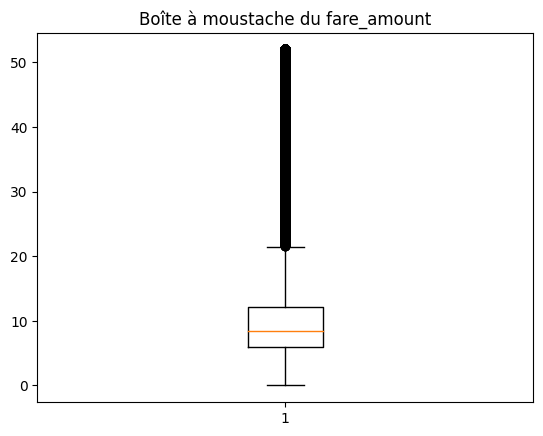

In [ ]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du fare_amount")
plt.show()

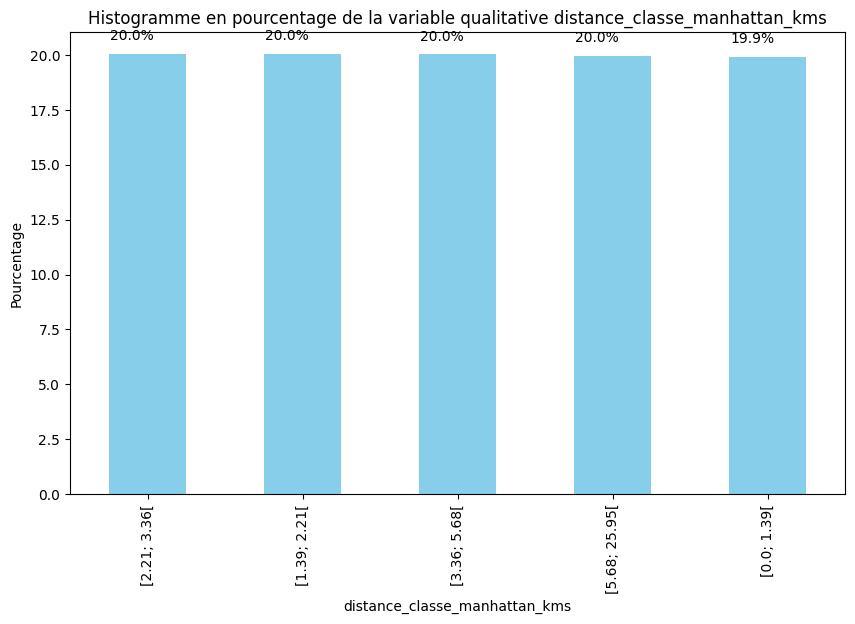

In [ ]:
variable_quali = 'distance_classe_manhattan_kms'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

In [ ]:
#variable_quali = 'type_vehicule'

# Calculer les pourcentages
#percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
#plt.figure(figsize=(10, 6))
#bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
#plt.xlabel(variable_quali)
#plt.ylabel('Pourcentage')
#plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
#for bar, percentage in zip(bars.patches, percentages):
#    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
#plt.show()

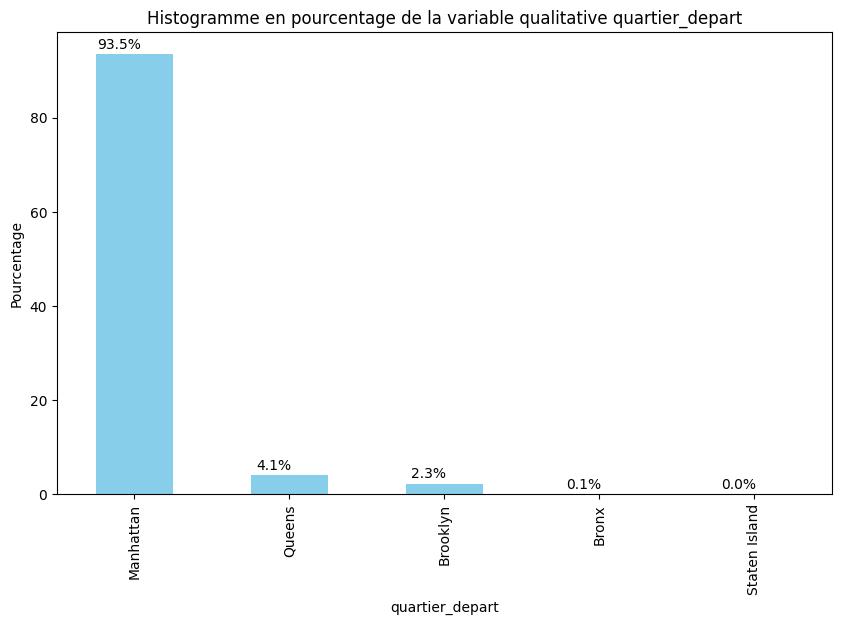

In [ ]:
variable_quali = 'quartier_depart'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

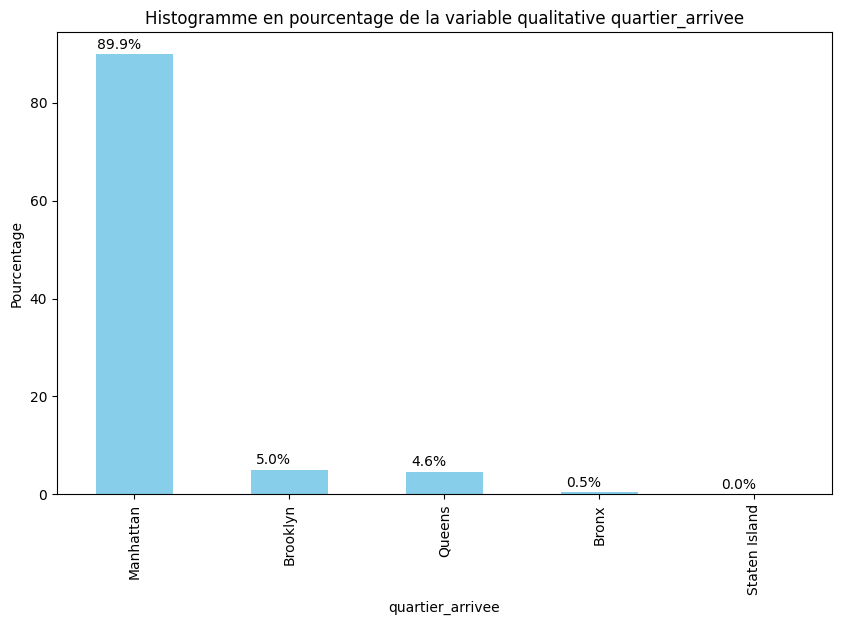

In [ ]:
variable_quali = 'quartier_arrivee'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

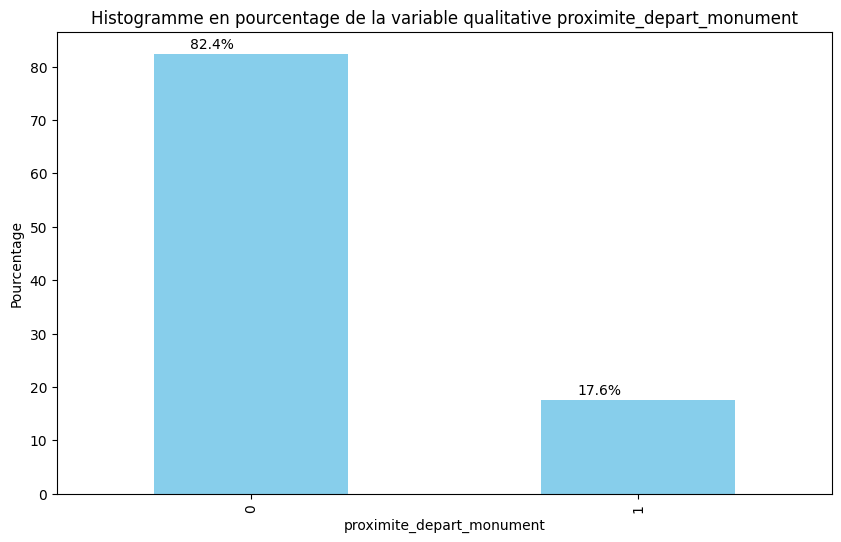

In [ ]:
variable_quali = 'proximite_depart_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

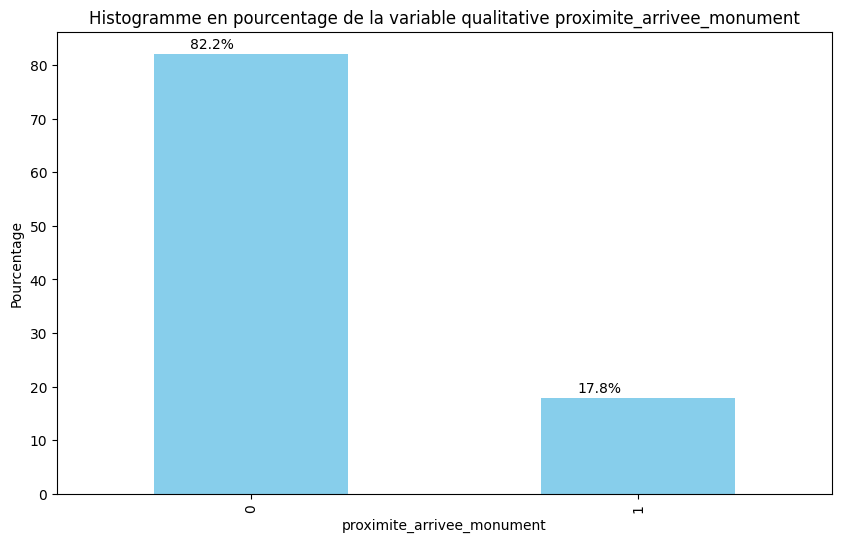

In [ ]:
variable_quali = 'proximite_arrivee_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

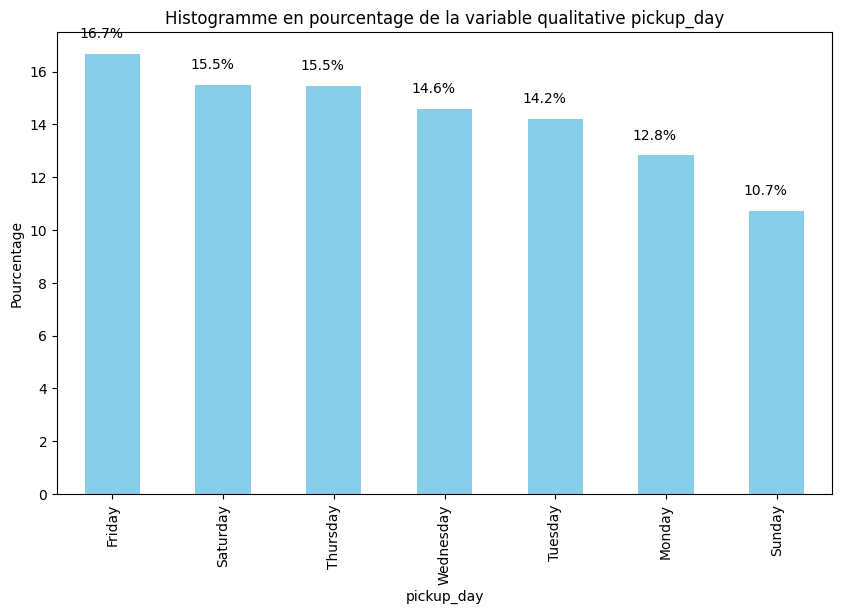

In [ ]:
variable_quali = 'pickup_day'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

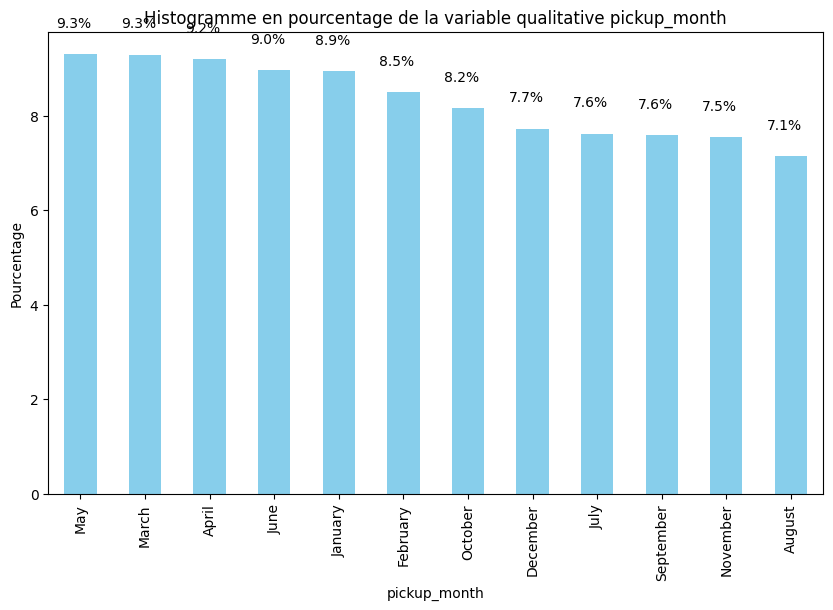

In [ ]:
variable_quali = 'pickup_month'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

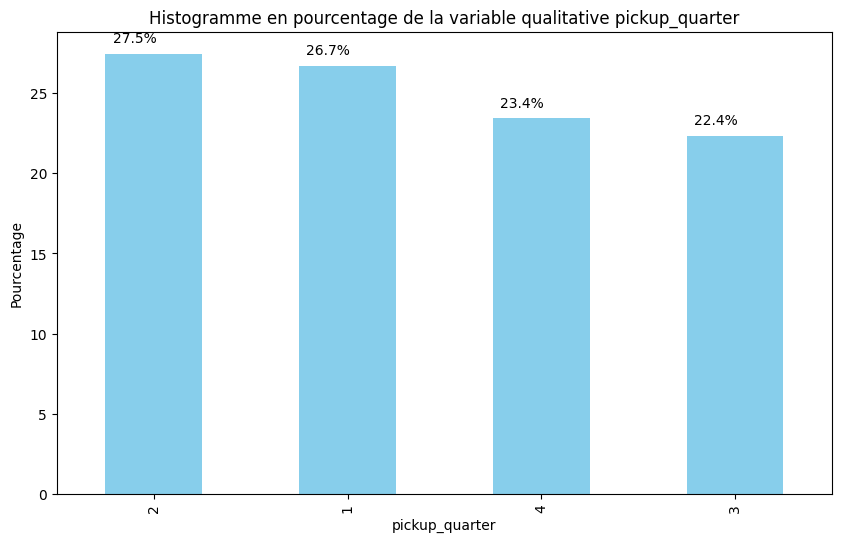

In [ ]:
variable_quali = 'pickup_quarter'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

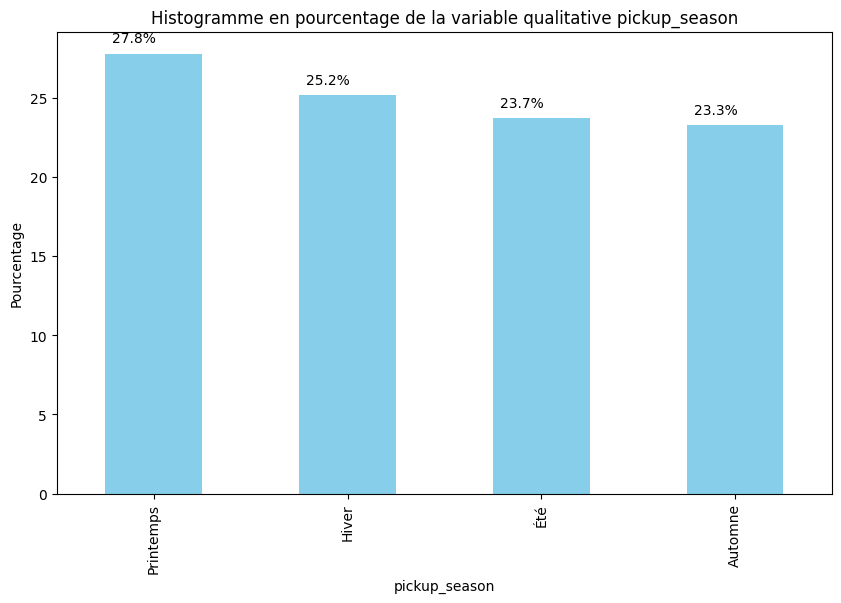

In [ ]:
variable_quali = 'pickup_season'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

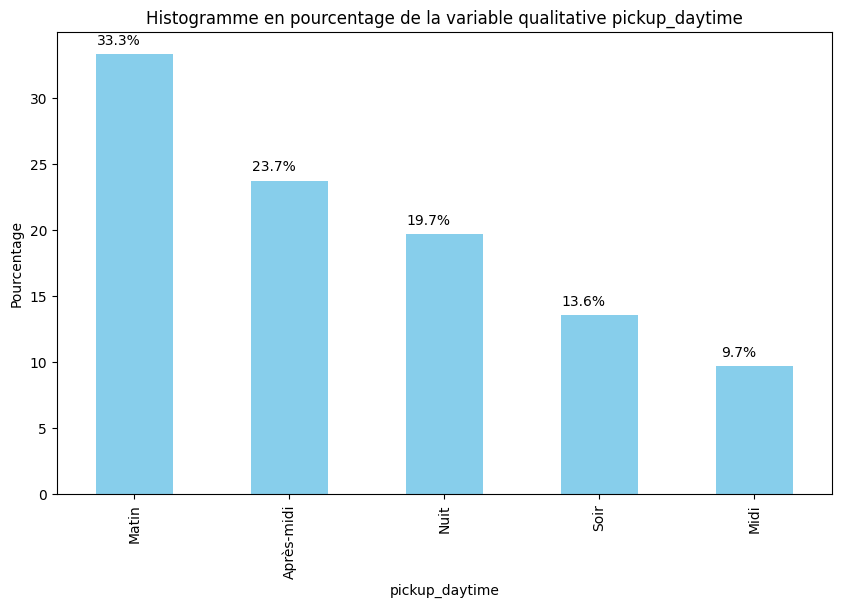

In [ ]:
variable_quali = 'pickup_daytime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

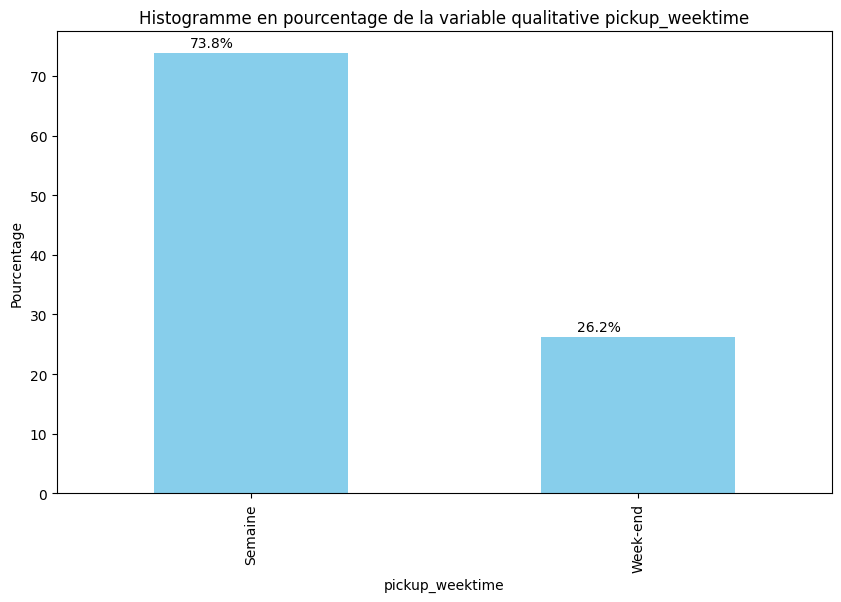

In [ ]:
variable_quali = 'pickup_weektime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

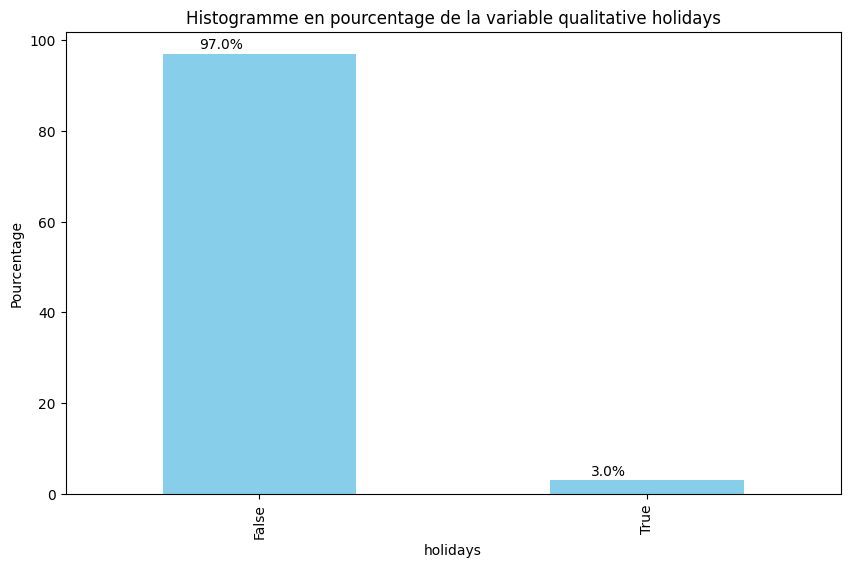

In [ ]:
variable_quali = 'holidays'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

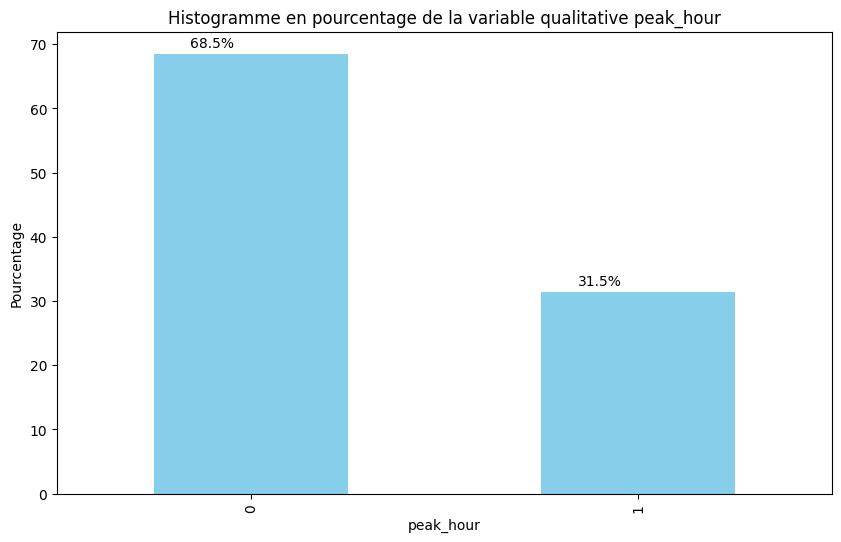

In [ ]:
variable_quali = 'peak_hour'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

In [ ]:
# test de garder la distance sans mise en classes
#taxi_test.drop("distance_classe_manhattan_kms", axis=1, inplace=True)

In [ ]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 467832  individus et  22  variables.


In [ ]:
# suppression des variables qui n'ont aucun intérêt dans le modèle
taxi_test.drop("pickup_longitude", axis=1, inplace=True)
taxi_test.drop("pickup_latitude", axis=1, inplace=True)
taxi_test.drop("dropoff_longitude", axis=1, inplace=True)
taxi_test.drop("dropoff_latitude", axis=1, inplace=True)
taxi_test.drop("datedep", axis=1, inplace=True)
taxi_test.drop("distance_classe_manhattan_kms", axis=1, inplace=True)

In [ ]:
taxi_test.head()

,fare_amount,passenger_count,manhattan_distance_km,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_season,pickup_daytime,pickup_weektime,holidays,peak_hour,New York City Average ($/gal)
0,11.5,1,3.913640,Manhattan,Manhattan,1,0,Monday,March,1,Printemps,Soir,Semaine,False,0,4.05
1,13.3,1,6.732953,Manhattan,Brooklyn,0,0,Friday,February,1,Hiver,Midi,Semaine,False,0,2.13
2,7.0,1,2.126051,Manhattan,Manhattan,0,1,Friday,September,3,Automne,Soir,Semaine,False,1,3.77
3,12.1,1,3.366088,Manhattan,Manhattan,0,0,Monday,December,4,Hiver,Après-midi,Semaine,False,0,3.23
4,3.7,1,1.173980,Manhattan,Manhattan,1,1,Tuesday,July,3,Été,Nuit,Semaine,False,0,3.93


# **Suppression des variables**

**Analyse des variables qualitatives**

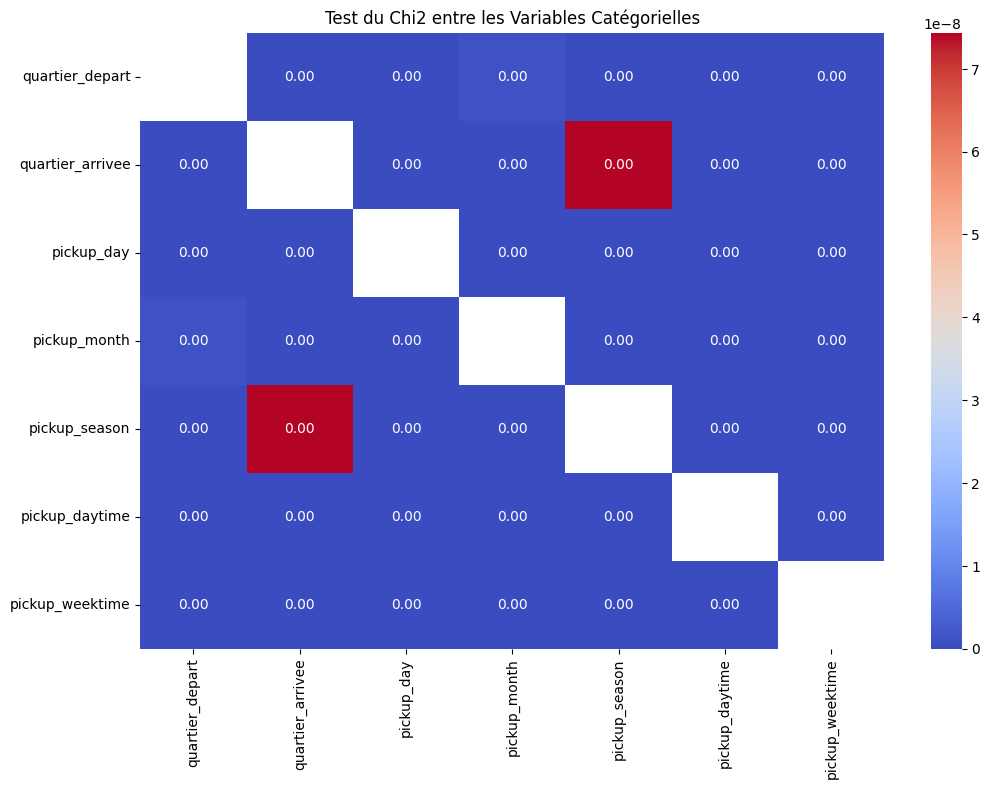

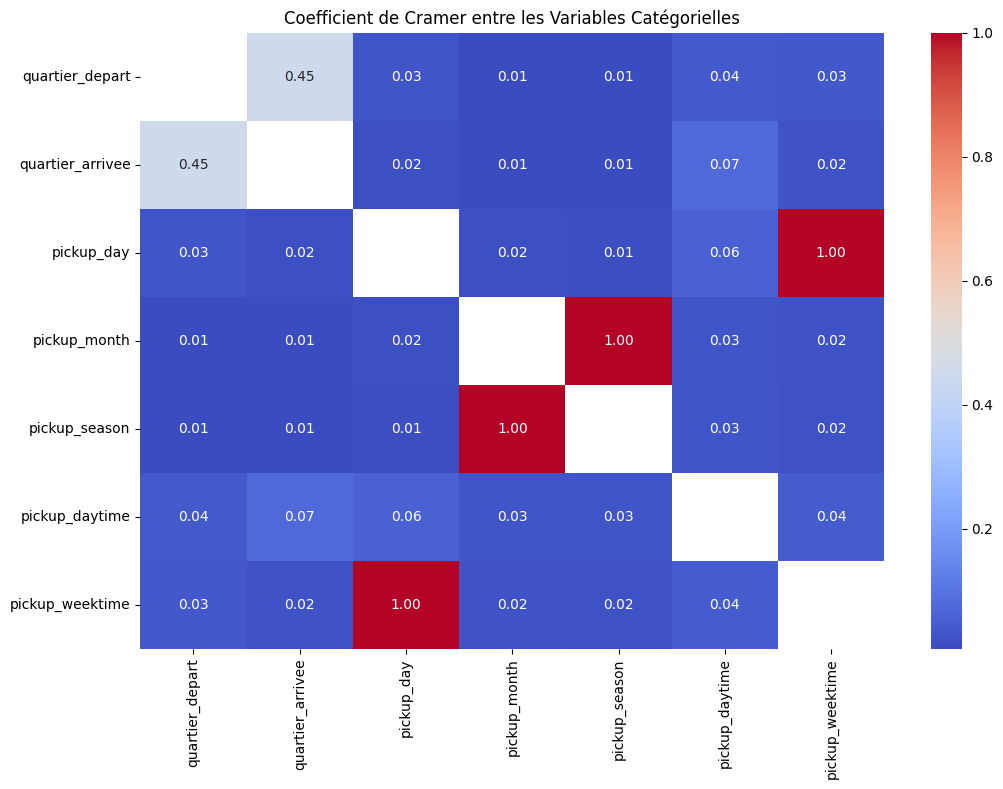

In [ ]:
# Sélectionner uniquement les variables catégorielles
categorical_columns = taxi_test.select_dtypes(include=['object']).columns

# Créer une table de contingence pour chaque paire de variables catégorielles
contingency_tables = {}
for col1 in categorical_columns:
    contingency_tables[col1] = {}
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = pd.crosstab(taxi_test[col1], taxi_test[col2])
            contingency_tables[col1][col2] = contingency_table

# Calculer le test du Chi2 et le coefficient de Cramer pour chaque paire de variables catégorielles
chi2_pvalues = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)
cramer_v = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = contingency_tables[col1][col2]
            chi2, p, _, _ = chi2_contingency(contingency_table)
            chi2_pvalues.loc[col1, col2] = p
            cramer_v.loc[col1, col2] = np.sqrt(chi2 / (taxi_test.shape[0] * (min(contingency_table.shape) - 1)))

# Tracer une heatmap pour visualiser le test du Chi2
plt.figure(figsize=(12, 8))
sns.heatmap(chi2_pvalues, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Test du Chi2 entre les Variables Catégorielles')
plt.show()

# Tracer une heatmap pour visualiser le coefficient de Cramer
plt.figure(figsize=(12, 8))
sns.heatmap(cramer_v, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Coefficient de Cramer entre les Variables Catégorielles')
plt.show()

Nous avons lancé le modèle une première fois pour avoir un premier résultat. Nous avons eu du sur apprentissage entre notre train et notre test. Nous allons donc résoudre ce problème.

Nous avons donc réalisé un test du chi2 et un test du cramer sur nos variables explicatives qualitatives.
Au vu des résultats nous décidons d'enlever les variables 'pickup_weektime' et 'pickup_saison' qui nous apportent moins d'informations que les deux autres variables. Autre raison, la répartion des deux variables explicatives que nous gardons est aussi très bonne.

En relançant une deuxième fois notre modèle, nous observons que les variables 'quartier_depart' et 'quartier_arrivee' sont légèrement corrélées. Nous décidons de ne pas supprimer 'quartier_arrivee' au vu d'un chi2 à 0, même si le Cramer ressort.

Nous nous arrêtons ici concernant la suppression de variables trop corrélées entre elles.

In [ ]:
taxi_test.drop("pickup_weektime", axis=1, inplace=True)
taxi_test.drop("pickup_season", axis=1, inplace=True)
taxi_test.drop("quartier_arrivee", axis=1, inplace=True)

**Vérification après suppression des variables**

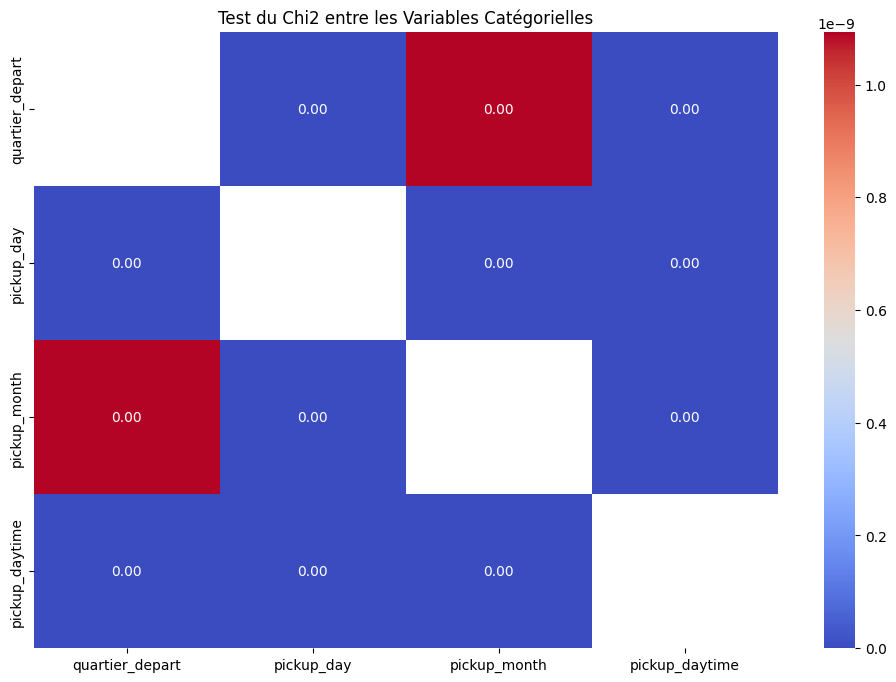

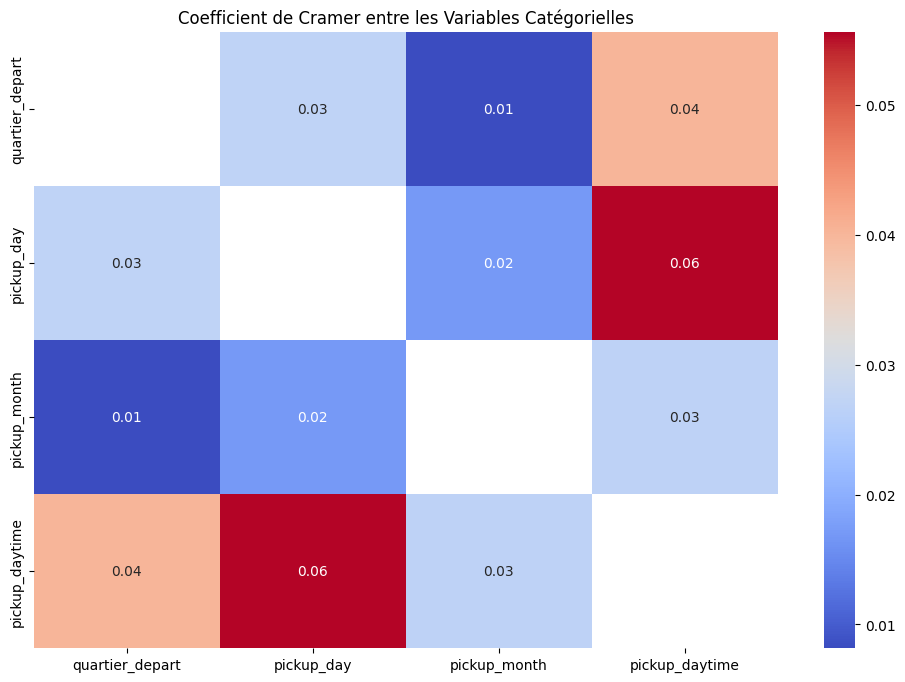

In [ ]:
# Sélectionner uniquement les variables catégorielles
categorical_columns = taxi_test.select_dtypes(include=['object']).columns

# Créer une table de contingence pour chaque paire de variables catégorielles
contingency_tables = {}
for col1 in categorical_columns:
    contingency_tables[col1] = {}
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = pd.crosstab(taxi_test[col1], taxi_test[col2])
            contingency_tables[col1][col2] = contingency_table

# Calculer le test du Chi2 et le coefficient de Cramer pour chaque paire de variables catégorielles
chi2_pvalues = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)
cramer_v = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = contingency_tables[col1][col2]
            chi2, p, _, _ = chi2_contingency(contingency_table)
            chi2_pvalues.loc[col1, col2] = p
            cramer_v.loc[col1, col2] = np.sqrt(chi2 / (taxi_test.shape[0] * (min(contingency_table.shape) - 1)))

# Tracer une heatmap pour visualiser le test du Chi2
plt.figure(figsize=(12, 8))
sns.heatmap(chi2_pvalues, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Test du Chi2 entre les Variables Catégorielles')
plt.show()

# Tracer une heatmap pour visualiser le coefficient de Cramer
plt.figure(figsize=(12, 8))
sns.heatmap(cramer_v, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Coefficient de Cramer entre les Variables Catégorielles')
plt.show()

**Analyse des variables quantitatives**

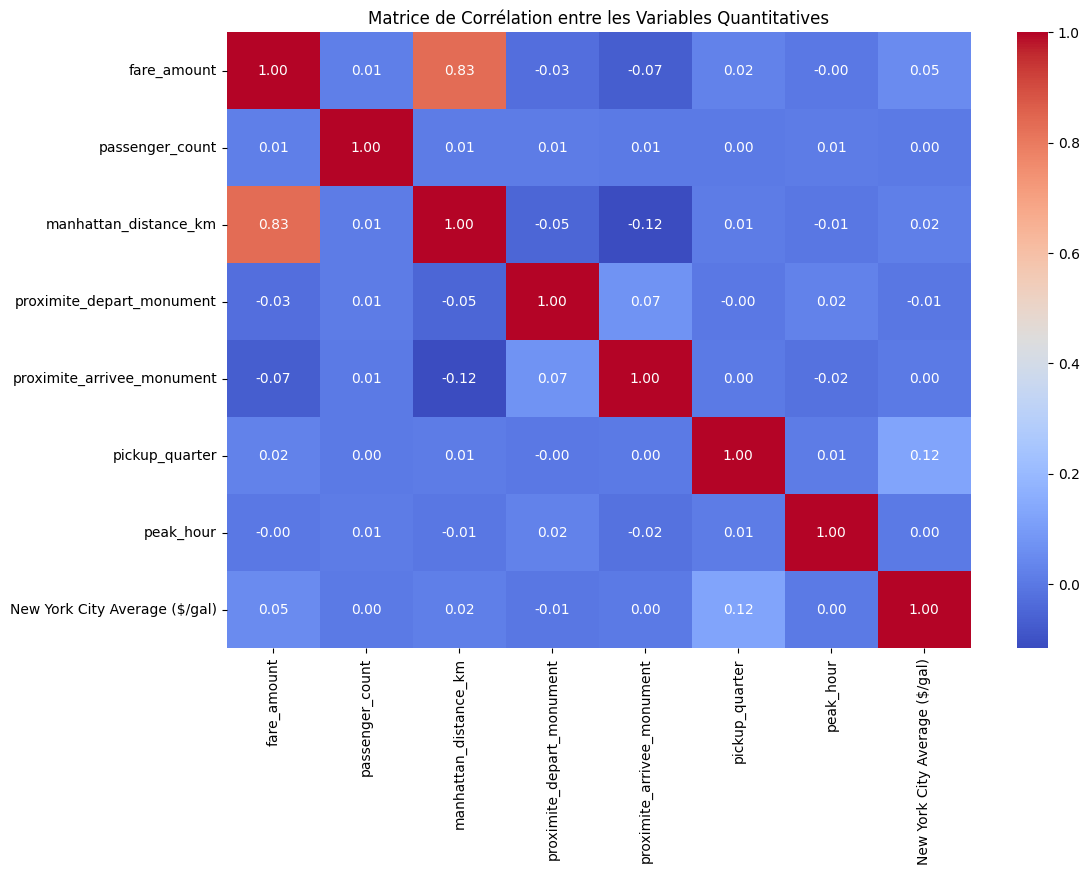

In [ ]:
# Sélectionner uniquement les variables quantitatives
numerical_columns = taxi_test.select_dtypes(include=['float64', 'int64']).columns

# Calculer la matrice de corrélation de Pearson
correlation_matrix = taxi_test[numerical_columns].corr()

# Tracer une heatmap pour visualiser la corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation entre les Variables Quantitatives')
plt.show()

Pour les variables quantitatives, nous n'avons pas de problème de forte corrélation entre les variables explicatives. La forte corrélation entre la variable de distance et le prix nous conforte sur la création de cette variable pour prédire le prix du taxi

In [ ]:
taxi_test.head()

,fare_amount,passenger_count,manhattan_distance_km,quartier_depart,proximite_depart_monument,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_daytime,holidays,peak_hour,New York City Average ($/gal)
0,11.5,1,3.913640,Manhattan,1,0,Monday,March,1,Soir,False,0,4.05
1,13.3,1,6.732953,Manhattan,0,0,Friday,February,1,Midi,False,0,2.13
2,7.0,1,2.126051,Manhattan,0,1,Friday,September,3,Soir,False,1,3.77
3,12.1,1,3.366088,Manhattan,0,0,Monday,December,4,Après-midi,False,0,3.23
4,3.7,1,1.173980,Manhattan,1,1,Tuesday,July,3,Nuit,False,0,3.93


# Machine Learning

A exécuter uniquement si après pour réentrainer le modèle avec uniquement la distance

In [ ]:
taxi_test.drop("passenger_count", axis=1, inplace=True)
taxi_test.drop("quartier_depart", axis=1, inplace=True)
taxi_test.drop("proximite_depart_monument", axis=1, inplace=True)
taxi_test.drop("proximite_arrivee_monument", axis=1, inplace=True)
taxi_test.drop("pickup_day", axis=1, inplace=True)
taxi_test.drop("pickup_month", axis=1, inplace=True)
taxi_test.drop("pickup_quarter", axis=1, inplace=True)
taxi_test.drop("pickup_daytime", axis=1, inplace=True)
taxi_test.drop("holidays", axis=1, inplace=True)
taxi_test.drop("peak_hour", axis=1, inplace=True)
taxi_test.drop("New York City Average ($/gal)", axis=1, inplace=True)

In [ ]:
taxi_test.head()

,fare_amount,manhattan_distance_km
0,11.5,3.913640
1,13.3,6.732953
2,7.0,2.126051
3,12.1,3.366088
4,3.7,1.173980


**Random Forest**

Pas oublier d'enlever les # si l'entrainement du modèle doit se faire sur la totalité du train ou uniquement sur la distance (pour appliquer l'arbre sur le test)

In [ ]:
# Création des dummies pour les variables catégorielles
# taxi_test_dummies = pd.get_dummies(taxi_test, columns=['quartier_depart', 'pickup_day', 'pickup_month', 'pickup_quarter', 'pickup_daytime', 'holidays'], drop_first=True)
#'pickup_season', 'pickup_weektime', 'quartier_arrivee',

# Séparer les données en ensemble d'entraînement et ensemble de test
#X = taxi_test_dummies.drop('fare_amount', axis=1)
#y = taxi_test_dummies['fare_amount']
X = taxi_test.drop('fare_amount', axis=1)
y = taxi_test['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser le modèle Random Forest
random_forest_model = RandomForestRegressor(n_estimators=50, random_state=2, max_depth = 4)

# Entraîner le modèle
random_forest_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions_test = random_forest_model.predict(X_test)

# Évaluer les performances du modèle
r2_test = r2_score(y_test, predictions_test)
print(f'R² Score sur l\'ensemble du test : {r2_test}')

# Faire des prédictions sur l'ensemble d'entraînement
predictions_train = random_forest_model.predict(X_train)

# Évaluer les performances sur l'ensemble d'entraînement
r2_train = r2_score(y_train, predictions_train)
print(f'R² Score sur l\'ensemble d\'entraînement : {r2_train}')

R² Score sur l'ensemble du test : 0.7119470104029454
R² Score sur l'ensemble d'entraînement : 0.714602151413517


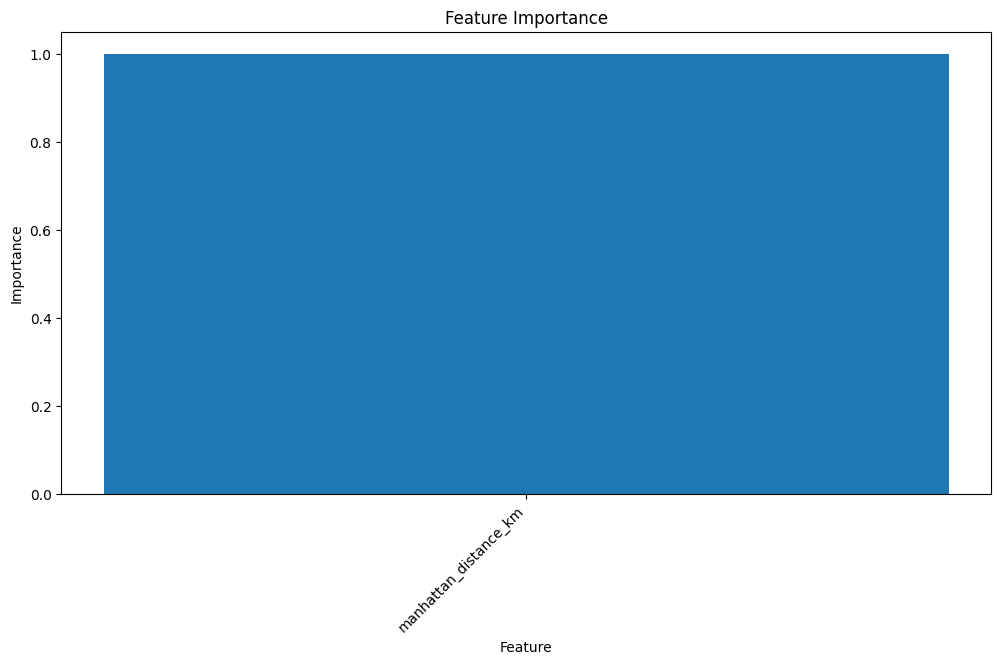

In [ ]:
# Obtenir les importances des caractéristiques depuis le modèle
feature_importances = random_forest_model.feature_importances_

# Créer un DataFrame pour une meilleure visualisation
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Trier le DataFrame par importance (de manière décroissante)
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Afficher l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotation des noms de features pour une meilleure lisibilité
plt.show()

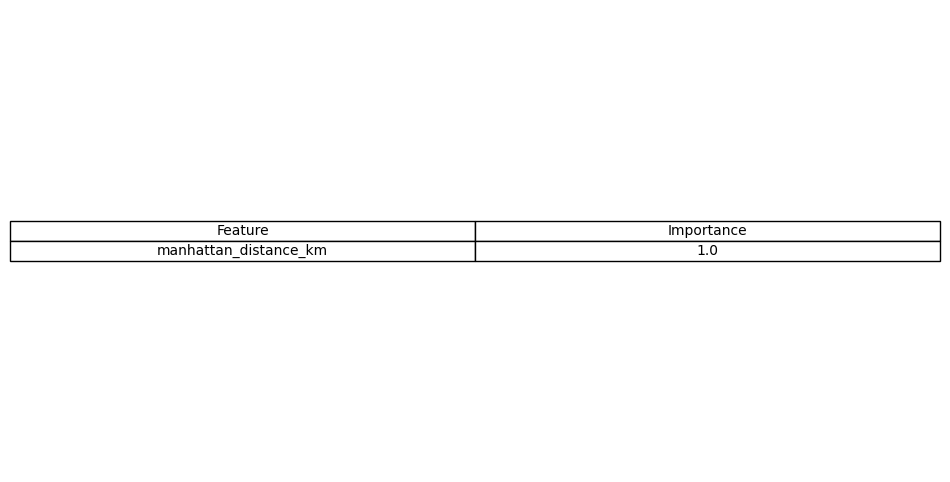

In [ ]:
# Afficher le tableau sous forme de graphique
fig, ax = plt.subplots(figsize=(10, 6))
table = ax.table(cellText=importances_df.values, colLabels=importances_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')
plt.show()

In [ ]:
pearson_corr, _ = pearsonr(y_test, predictions_test)
print(f'Pearson Correlation Coefficient : {pearson_corr}')

Pearson Correlation Coefficient : 0.8438197032360255


La validation croisée va permettre de tester le modèle sur plusieurs partie de l'échantillon d'apprentissage (va ici diviser l'échantillon en 5 parties), il va entraîner le modèle sur 4 plis, puis l'évalue sur le pli restant. Cela est répété pour chaque pli, et les scores sont renvoyés. La moyenne des scores vous donne une estimation globale des performances du modèle.

In [ ]:
# Utilisation la fonction cross_val_score pour effectuer une validation croisée
# cv est le nombre de plis, par exemple 5 pour une validation croisée à 5 plis
scores = cross_val_score(random_forest_model, X, y, cv=5)

print("Scores par pli:", scores)
print("Moyenne des scores:", scores.mean())

Scores par pli: [0.7102807  0.7163975  0.70945443 0.71127355 0.71717658]
Moyenne des scores: 0.7129165510698019


On retrouve bien des scores toujours en dessous de l'apprentissage qui confirme un sur apprentissage de notre modèle.

Nous allons donc rajouter en paramètre 'max_depth = 4' qui va nous permettre de limiter la profondeur des arbres à 4 niveau ce qui peut limiter le sur-apprentissage (qui n'est ici pas lié aux variables explicatives, car déjà testé). Suite à un essai de plusieurs valeurs de ce paramètre, pour éviter le sur apprentissage, un niveau à 4 semble être le meilleur choix.

Nous relançons alors le modèle et le problème est alors réglé.

**Arbre de décision**

In [ ]:
# Initialiser le modèle d'arbre de décision
decision_tree_model = DecisionTreeRegressor(max_depth=4, random_state=2)

# Entraîner le modèle
decision_tree_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions_test = decision_tree_model.predict(X_test)

# Évaluer les performances du modèle sur l'ensemble de test
r2_test = r2_score(y_test, predictions_test)
print(f'R² Score sur l\'ensemble du test : {r2_test}')

# Faire des prédictions sur l'ensemble d'entraînement
predictions_train = decision_tree_model.predict(X_train)

# Évaluer les performances sur l'ensemble d'entraînement
r2_train = r2_score(y_train, predictions_train)
print(f'R² Score sur l\'ensemble d\'entraînement : {r2_train}')

R² Score sur l'ensemble du test : 0.7100250852681533
R² Score sur l'ensemble d'entraînement : 0.7128576713072337


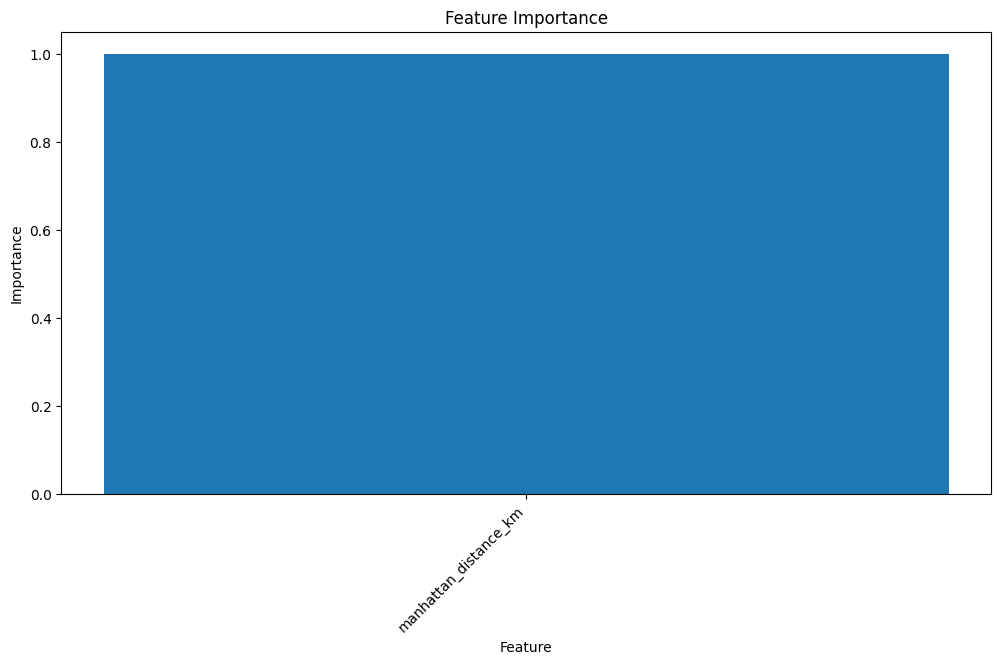

In [ ]:
# Obtenir les importances des caractéristiques depuis le modèle
feature_importances = decision_tree_model.feature_importances_

# Créer un DataFrame pour une meilleure visualisation
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Trier le DataFrame par importance (de manière décroissante)
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Afficher l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotation des noms de features pour une meilleure lisibilité
plt.show()

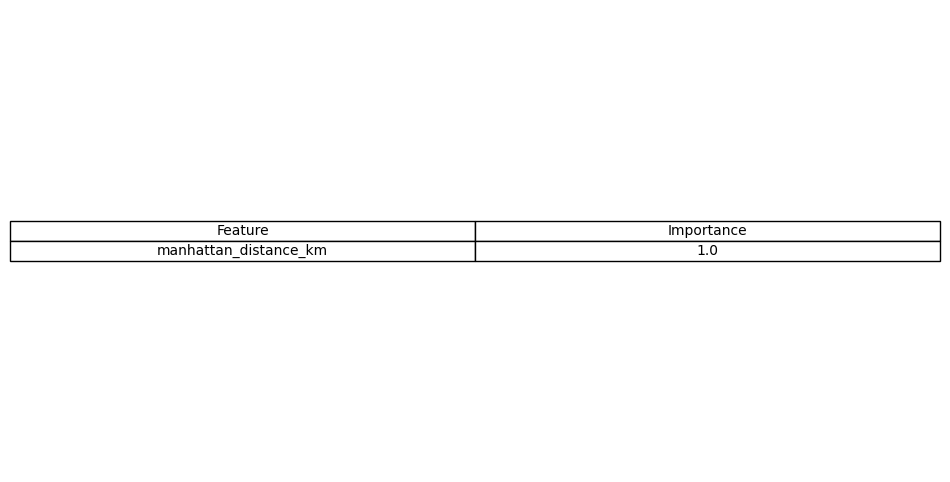

In [ ]:
# Afficher le tableau sous forme de graphique
fig, ax = plt.subplots(figsize=(10, 6))
table = ax.table(cellText=importances_df.values, colLabels=importances_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')
plt.show()

In [ ]:
pearson_corr, _ = pearsonr(y_test, predictions_test)
print(f'Pearson Correlation Coefficient : {pearson_corr}')

Pearson Correlation Coefficient : 0.8426604646181657


In [ ]:
# Utilisation la fonction cross_val_score pour effectuer une validation croisée
# cv est le nombre de plis, par exemple 5 pour une validation croisée à 5 plis
scores = cross_val_score(random_forest_model, X, y, cv=5)

print("Scores par pli:", scores)
print("Moyenne des scores:", scores.mean())

Scores par pli: [0.7102807  0.7163975  0.70945443 0.71127355 0.71717658]
Moyenne des scores: 0.7129165510698019


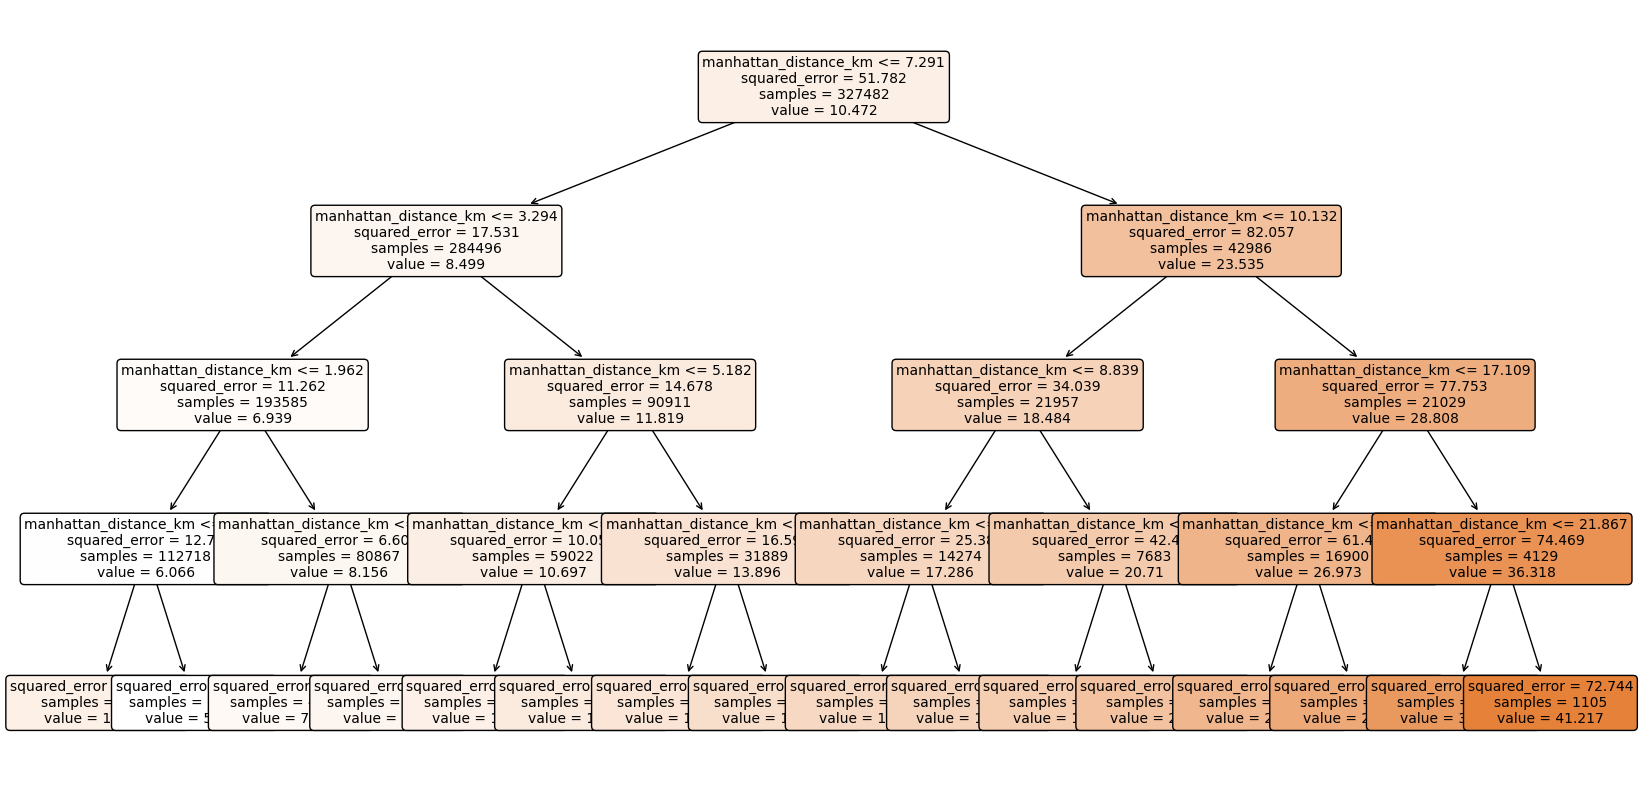

In [ ]:
# Afficher l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, rounded=True, fontsize=10, class_names=True)
plt.show()

**Regression linéaire**

In [ ]:
# Initialiser le modèle de régression linéaire
linear_regression_model = LinearRegression()

# Entraîner le modèle
linear_regression_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions_test = linear_regression_model.predict(X_test)

# Évaluer les performances du modèle
r2_test = r2_score(y_test, predictions_test)
print(f'R² Score sur l\'ensemble du test : {r2_test}')

# Faire des prédictions sur l'ensemble d'entraînement
predictions_train = linear_regression_model.predict(X_train)

# Évaluer les performances sur l'ensemble d'entraînement
r2_train = r2_score(y_train, predictions_train)
print(f'R² Score sur l\'ensemble d\'entraînement : {r2_train}')

R² Score sur l'ensemble du test : 0.6940272671361583
R² Score sur l'ensemble d'entraînement : 0.6968858964990371


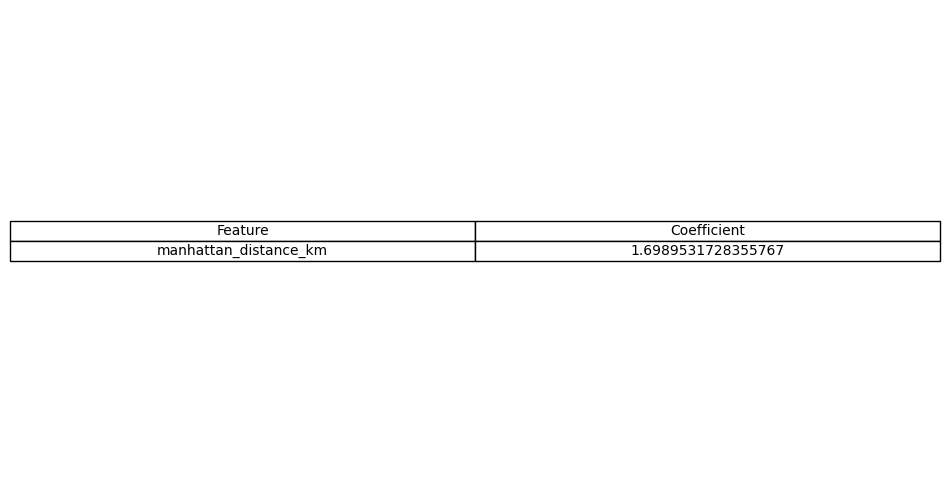

In [ ]:
# Obtenir les coefficients de régression
coefficients = linear_regression_model.coef_

# Créer un DataFrame pour une meilleure visualisation
importances_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Trier le DataFrame par coefficient (de manière décroissante)
importances_df = importances_df.sort_values(by='Coefficient', ascending=False)

# Afficher le tableau sous forme de graphique
fig, ax = plt.subplots(figsize=(10, 6))
table = ax.table(cellText=importances_df.values, colLabels=importances_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')
plt.show()

In [ ]:
pearson_corr, _ = pearsonr(y_test, predictions_test)
print(f'Pearson Correlation Coefficient : {pearson_corr}')

Pearson Correlation Coefficient : 0.8331142460696385


In [ ]:
# Utilisation la fonction cross_val_score pour effectuer une validation croisée
# cv est le nombre de plis, par exemple 5 pour une validation croisée à 5 plis
scores = cross_val_score(random_forest_model, X, y, cv=5)

print("Scores par pli:", scores)
print("Moyenne des scores:", scores.mean())

Scores par pli: [0.7102807  0.7163975  0.70945443 0.71127355 0.71717658]
Moyenne des scores: 0.7129165510698019


# **Application du modèle sur le test**

In [ ]:
# Chemin vers votre fichier CSV
chemin_du_fichier_csv = '/content/drive/MyDrive/Projet BIG DATA/test.csv'

test = pd.read_csv(chemin_du_fichier_csv)

In [ ]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [ ]:
# Convertisser la colonne pickup_datetime en type datetime
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# Définisser le fuseau horaire de destination (New York)
destination_timezone = pytz.timezone('America/New_York')

# Convertisser l'heure de pickup_datetime à l'heure de New York
test['pickup_datetime_ny'] = test['pickup_datetime'].dt.tz_convert(destination_timezone)

# Suppression de l'ancienne pickup_datetime
test = test.drop('pickup_datetime', axis=1)

In [ ]:
# On récupère que la date
test['datedep']=test['pickup_datetime_ny'].dt.date

In [ ]:
test['datedep'] = pd.to_datetime(test['datedep'], errors='coerce')

In [ ]:
test['manhattan_distance_km'] = test.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['pickup_longitude'])).kilometers +
                                               geodesic((row['dropoff_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)

Nous allons laisser dans le 'test' uniquement la variable de distance car nous gardons que celle ci pour entrainer notre modèle ainsi que la 'key' qui permettra de vérifier nos résultats avec un score Kaggle

In [ ]:
test.drop("pickup_longitude", axis=1, inplace=True)
test.drop("pickup_latitude", axis=1, inplace=True)
test.drop("dropoff_longitude", axis=1, inplace=True)
test.drop("dropoff_latitude", axis=1, inplace=True)
test.drop("passenger_count", axis=1, inplace=True)
test.drop("pickup_datetime_ny", axis=1, inplace=True)
test.drop("datedep", axis=1, inplace=True)

In [ ]:
test.head()

,key,manhattan_distance_km
0,2015-01-27 13:08:24.0000002,2.902620
1,2015-01-27 13:08:24.0000003,3.216303
2,2011-10-08 11:53:44.0000002,0.811074
3,2012-12-01 21:12:12.0000002,2.580262
4,2012-12-01 21:12:12.0000003,6.937808


In [ ]:
# Sélectionner la colonne 'manhattan_distance_km' du jeu de test pour faire des prédictions
X_test = test[['manhattan_distance_km']]
X_test.head()

,manhattan_distance_km
0,2.902620
1,3.216303
2,0.811074
3,2.580262
4,6.937808


In [ ]:
# Faire des prédictions sur le jeu de test
predictions_test = decision_tree_model.predict(X_test)

# Créer une variable 'fare_amount' dans le jeu de test avec les prédictions
test['fare_amount'] = predictions_test

test.head()

,key,manhattan_distance_km,fare_amount_prediction
0,2015-01-27 13:08:24.0000002,2.902620,8.810282
1,2015-01-27 13:08:24.0000003,3.216303,8.810282
2,2011-10-08 11:53:44.0000002,0.811074,5.872397
3,2012-12-01 21:12:12.0000002,2.580262,7.654233
4,2012-12-01 21:12:12.0000003,6.937808,14.976758


In [ ]:
test.drop("manhattan_distance_km", axis=1, inplace=True)

In [ ]:
# Export du DataFrame au format CSV
test.to_csv('/content/drive/MyDrive/Projet BIG DATA/sample_submission.csv', index=False)